## Code from AI-assisted session with Claude

### Recipe approach for EDA:

1. Load and inspect the dataset
2. Analyze the distribution of cheaters vs. non-cheaters
3. Examine the statistical properties of each feature
4. Visualize feature distributions and relationships
5. Analyze temporal patterns within engagements
6. Investigate differences between cheaters and non-cheaters
7. Identify potential outliers or anomalies
8. Explore correlations between features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
cheaters_data = np.load('csgo_dataset/cheaters/cheaters.npy')  # Replace with actual path
legit_data = np.load('csgo_dataset/legit/legit.npy')  # Replace with actual path

In [3]:
# Print basic information
print(f"Cheaters dataset shape: {cheaters_data.shape}")
print(f"Legitimate players dataset shape: {legit_data.shape}")

Cheaters dataset shape: (2000, 30, 192, 5)
Legitimate players dataset shape: (10000, 30, 192, 5)


In [4]:
# Calculate total number of players
total_players = cheaters_data.shape[0] + legit_data.shape[0]
total_players

12000

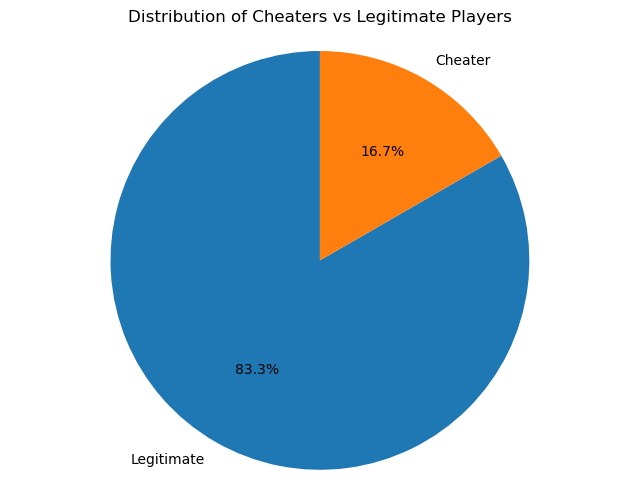

In [5]:
# Visualize cheater distribution
plt.figure(figsize=(8, 6))
labels = ['Legitimate', 'Cheater']
sizes = [legit_data.shape[0], cheaters_data.shape[0]]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Cheaters vs Legitimate Players')
plt.show()

In [ ]:
def compute_direct_stats(data, is_cheater):
    # Reshape data to combine all players and engagements
    reshaped_data = data.reshape(-1, data.shape[-1])
    
    stats = pd.DataFrame({
        'AttackerDeltaYaw': reshaped_data[:, 0],
        'AttackerDeltaPitch': reshaped_data[:, 1],
        'CrosshairToVictimYaw': reshaped_data[:, 2],
        'CrosshairToVictimPitch': reshaped_data[:, 3],
        'Firing': reshaped_data[:, 4]
    })
    
    stats['is_cheater'] = is_cheater
    
    return stats

# Compute statistics for both datasets
cheaters_stats = compute_direct_stats(cheaters_data, 1)
legit_stats = compute_direct_stats(legit_data, 0)

# Combine statistics
combined_stats = pd.concat([cheaters_stats, legit_stats], ignore_index=True)

# Display summary statistics
print(combined_stats.groupby('is_cheater').describe()) # Makes no sense in calculating summary stats on firing

# Visualize distributions
for column in combined_stats.columns[:-1]:  # Skip 'is_cheater'
    plt.figure(figsize=(10, 6))
    sns.histplot(data=combined_stats, x=column, hue='is_cheater', kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

           AttackerDeltaYaw                                              \
                      count      mean       std         min    25%  50%   
is_cheater                                                                
0                57600000.0 -0.004811  3.420612 -180.000000 -0.126  0.0   
1                11520000.0 -0.005151  3.300632 -179.697998 -0.126  0.0   

                              AttackerDeltaPitch            ...  \
              75%         max              count      mean  ...   
is_cheater                                                  ...   
0           0.132  179.863007         57600000.0  0.016608  ...   
1           0.137  179.686996         11520000.0  0.013963  ...   

           CrosshairToVictimPitch                  Firing                      \
                              75%         max       count      mean       std   
is_cheater                                                                      
0                           0.183  113.299004

💭 Claude couldn't understand that I wanted it to calculate summary stats of the variables and then plot the summary stats. Instead it kept trying to calculate summary stats of means and stds of variables and plotting the means and stds OR it calculated summart stats of the variables correctly but then plotted histograms of the raw variables instead of the summary stats. So, I just gave it the summary report and summarized the histograms myself and told it what the distributions looked like.

## Pivot to other kind of analysis

Given these observations, here are some suggestions for further exploration:

1. Temporal analysis: Look at how these features change over the course of an engagement. Cheaters might show more consistent patterns or sudden changes.
2. Correlation analysis: Examine if there are differences in how features correlate with each other for cheaters vs. non-cheaters.
3. Engagement-level statistics: Calculate statistics like the number of sudden movements (large deltas) or the precision of aiming (how often the crosshair is very close to the victim) for each engagement.
4. Sequence analysis: Look for specific patterns in the sequence of actions that might be more common among cheaters.
5. Dimensionality reduction: Apply techniques like PCA or t-SNE to see if cheaters and non-cheaters separate in a lower-dimensional space.

To proceed, I suggest we focus on temporal patterns within engagements. We could create visualizations that show how features change over the 192 timesteps, comparing typical patterns for cheaters and non-cheaters.

Here's an approach we can take:

1. Select a sample of engagements from both cheaters and non-cheaters.
2. Plot the time series of key features (AttackerDeltaYaw, AttackerDeltaPitch, CrosshairToVictimYaw, CrosshairToVictimPitch) for these engagements.
3. Calculate and visualize the rate of change for these features over time.
4. Identify instances of sudden, large movements and compare their frequency between cheaters and non-cheaters.

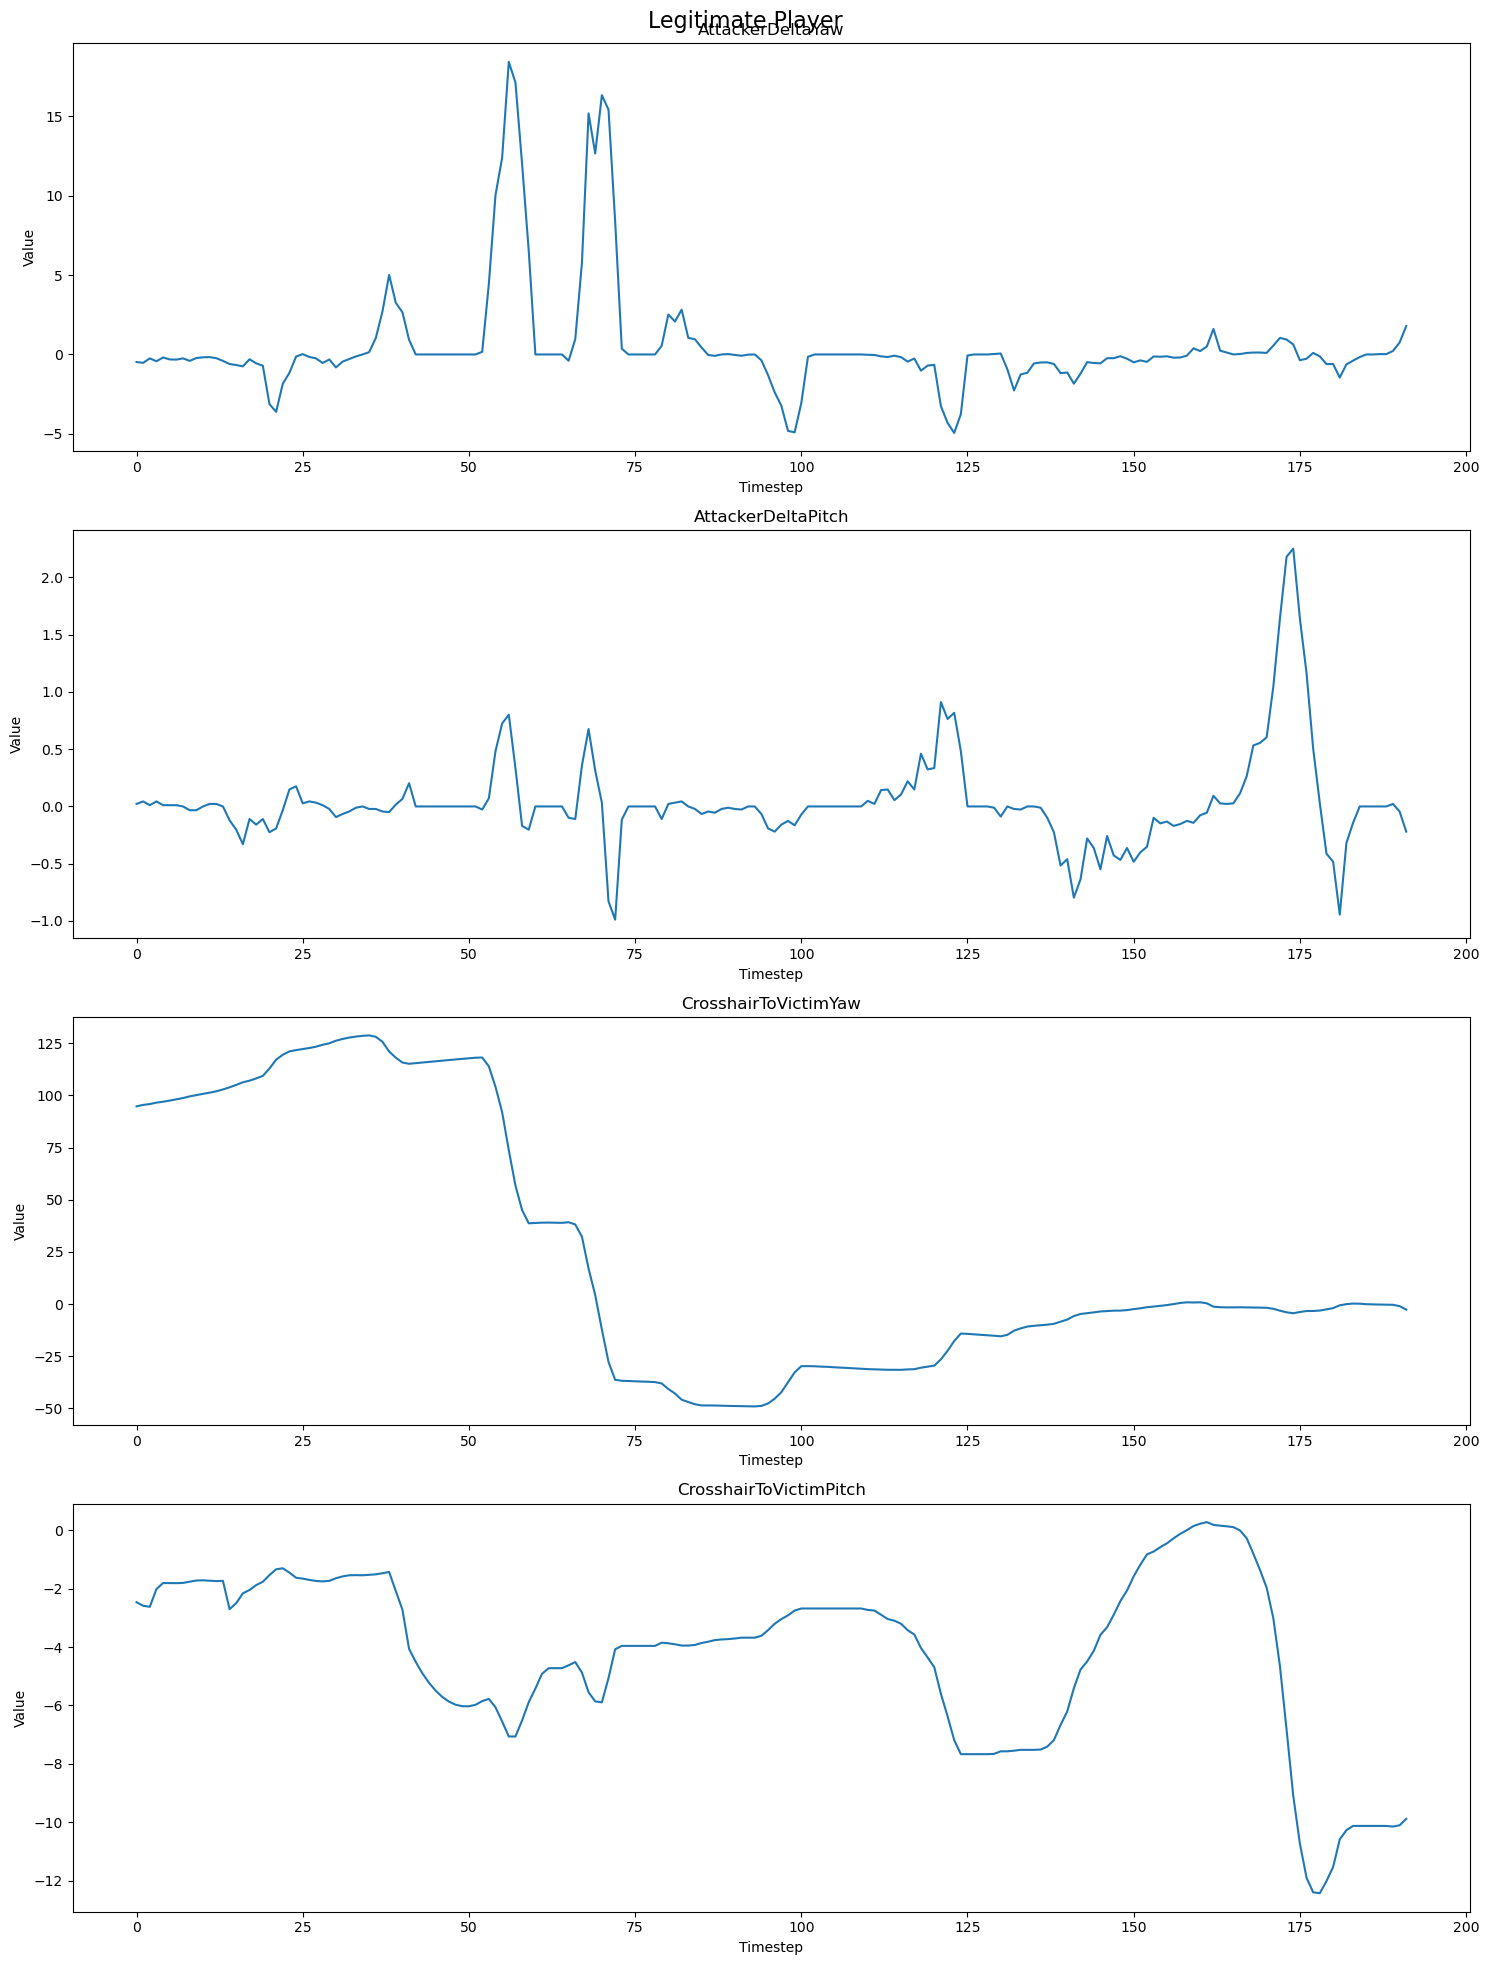

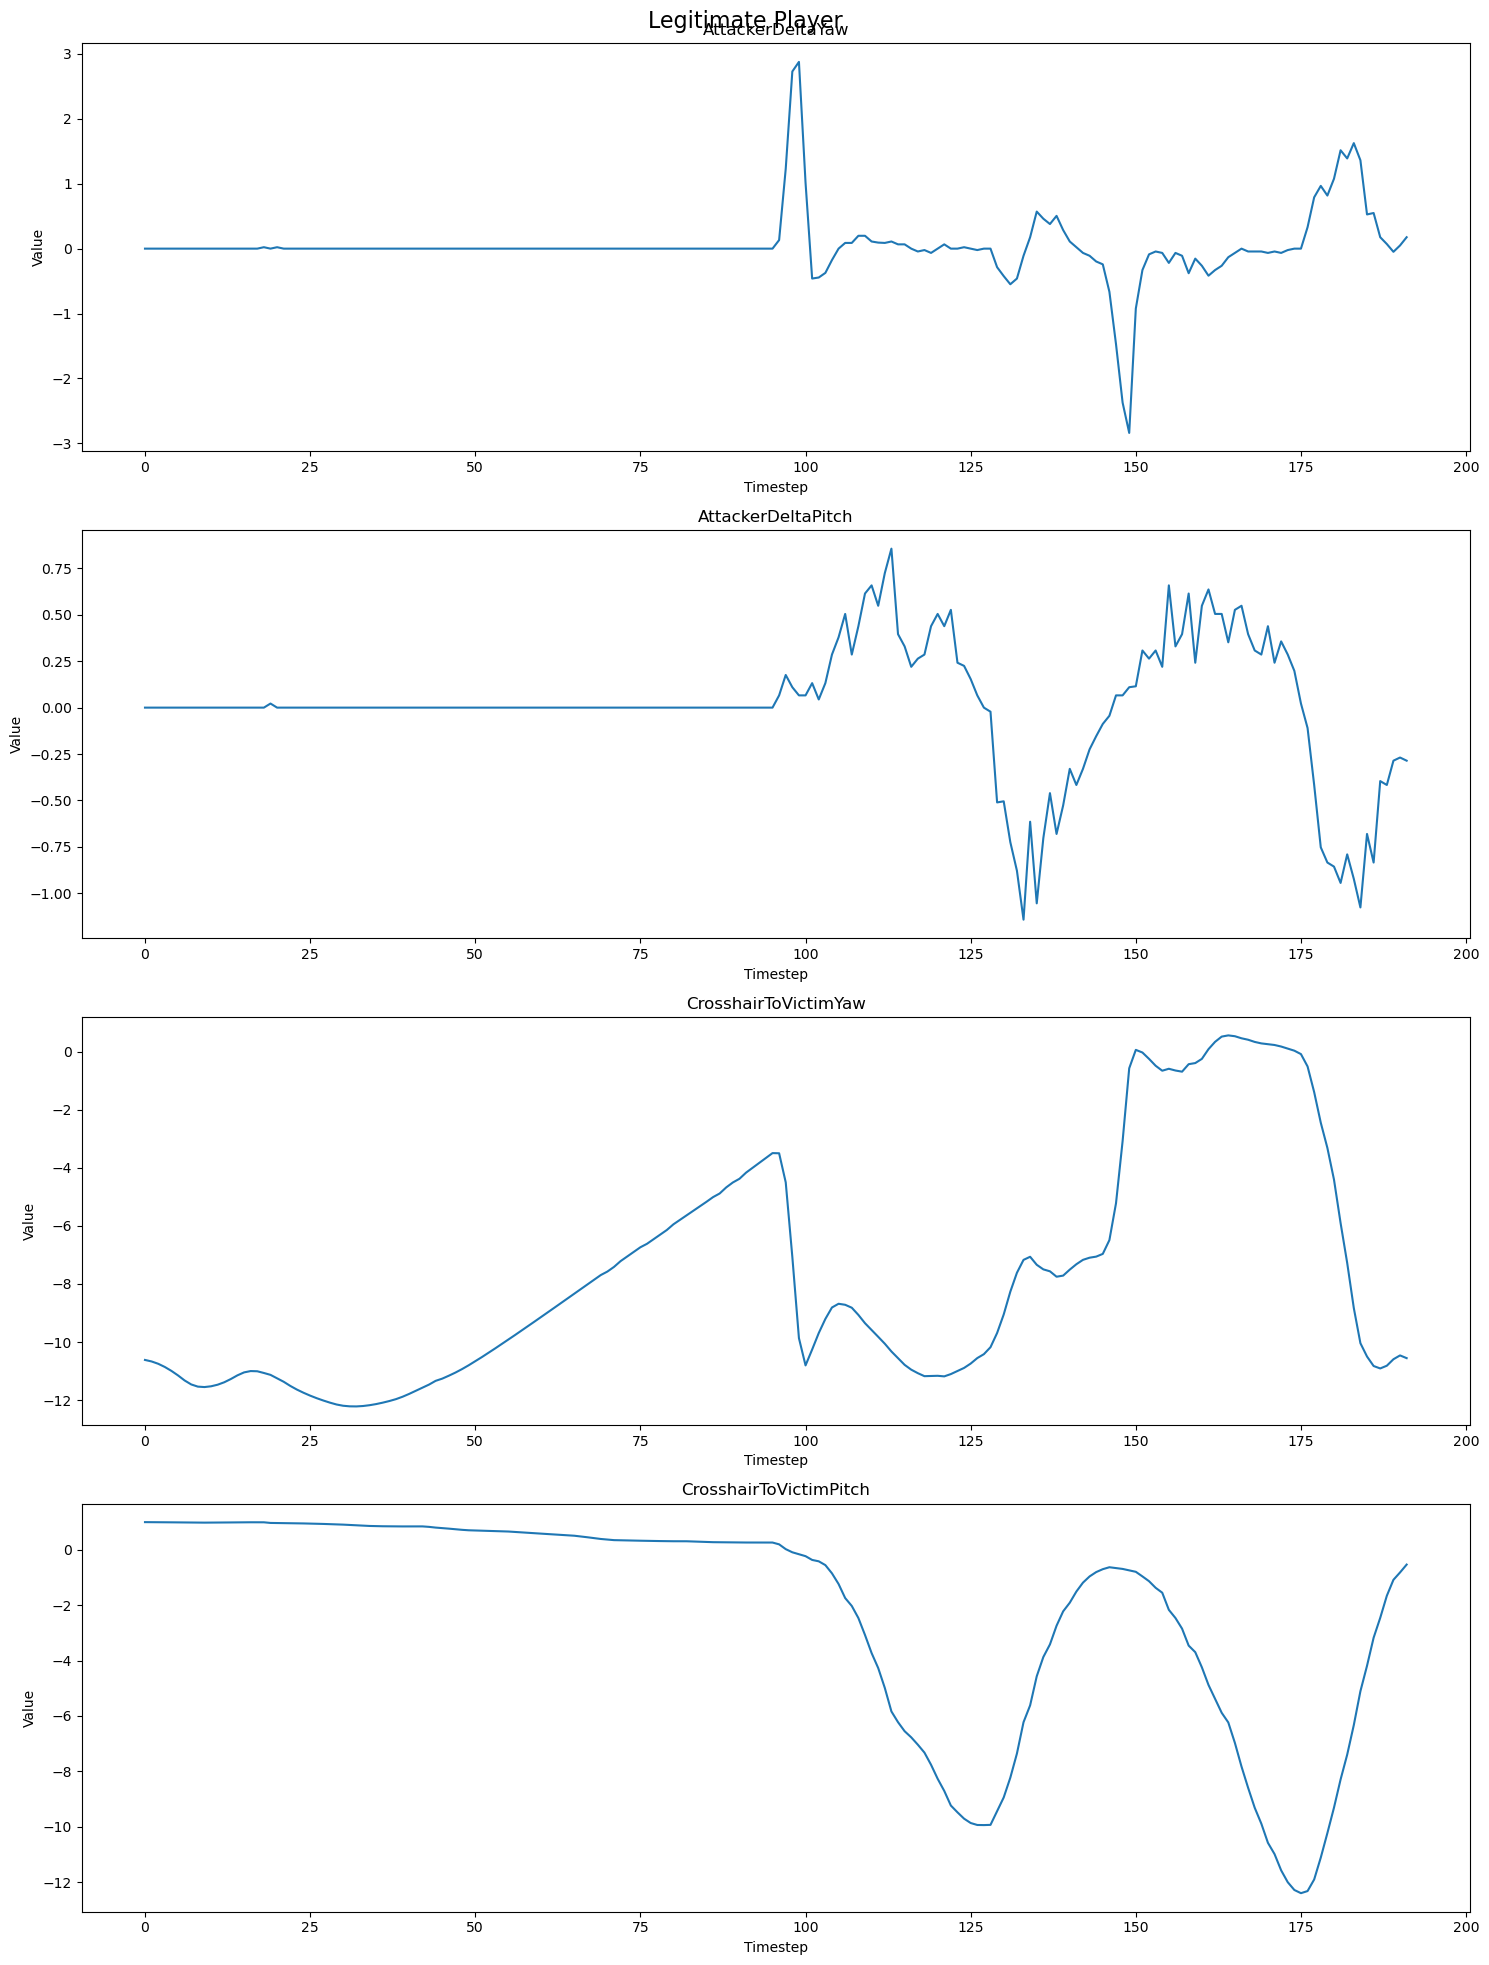

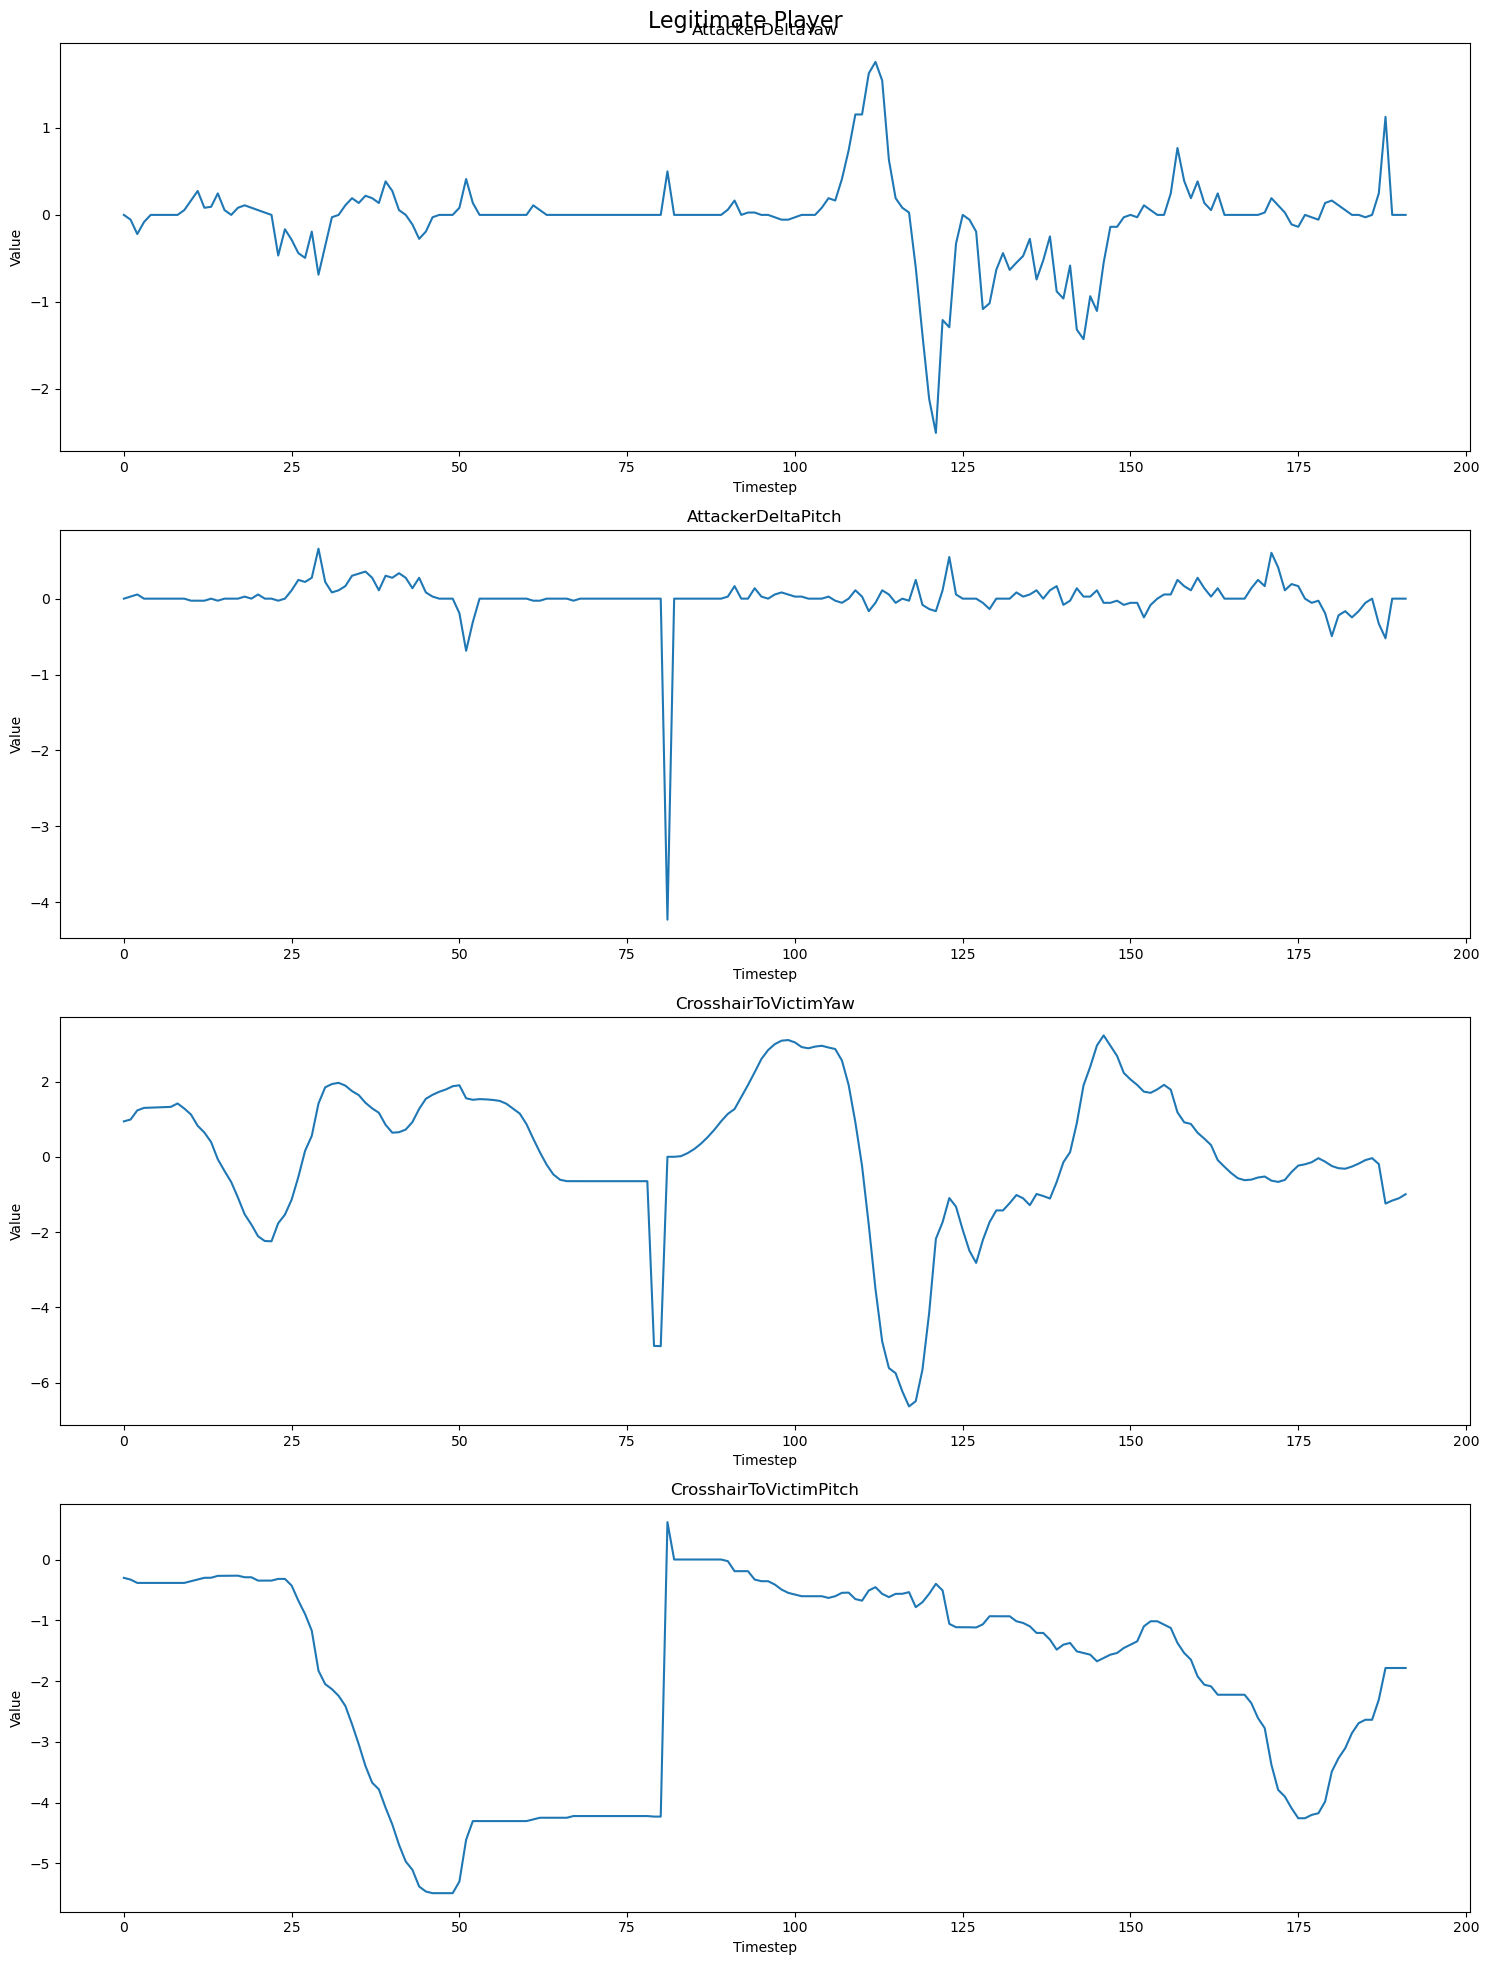

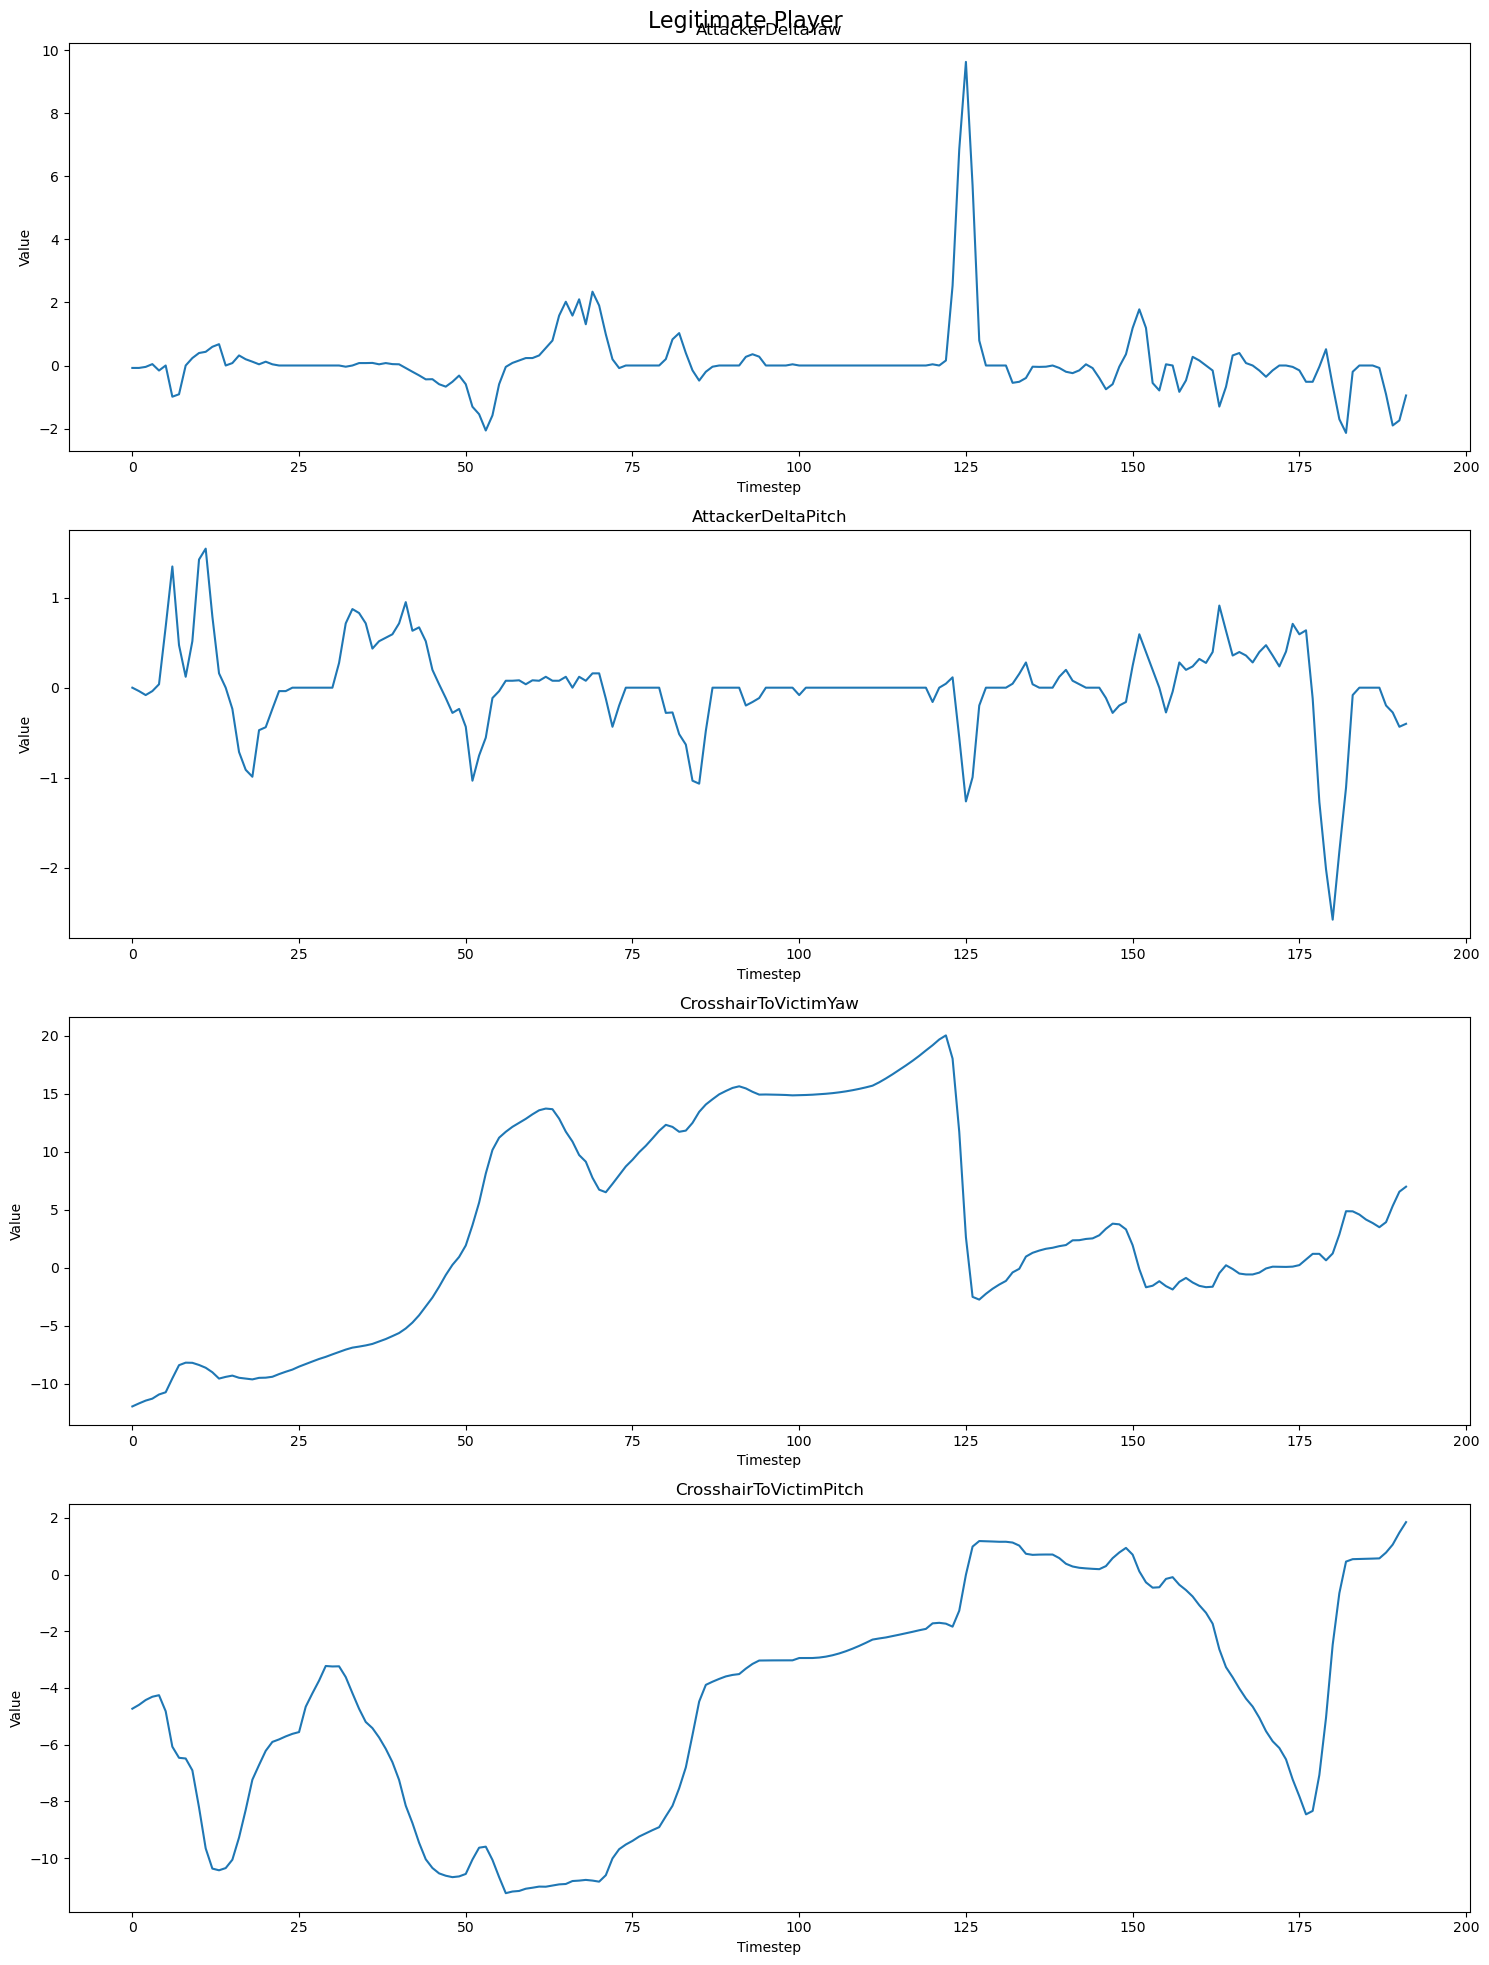

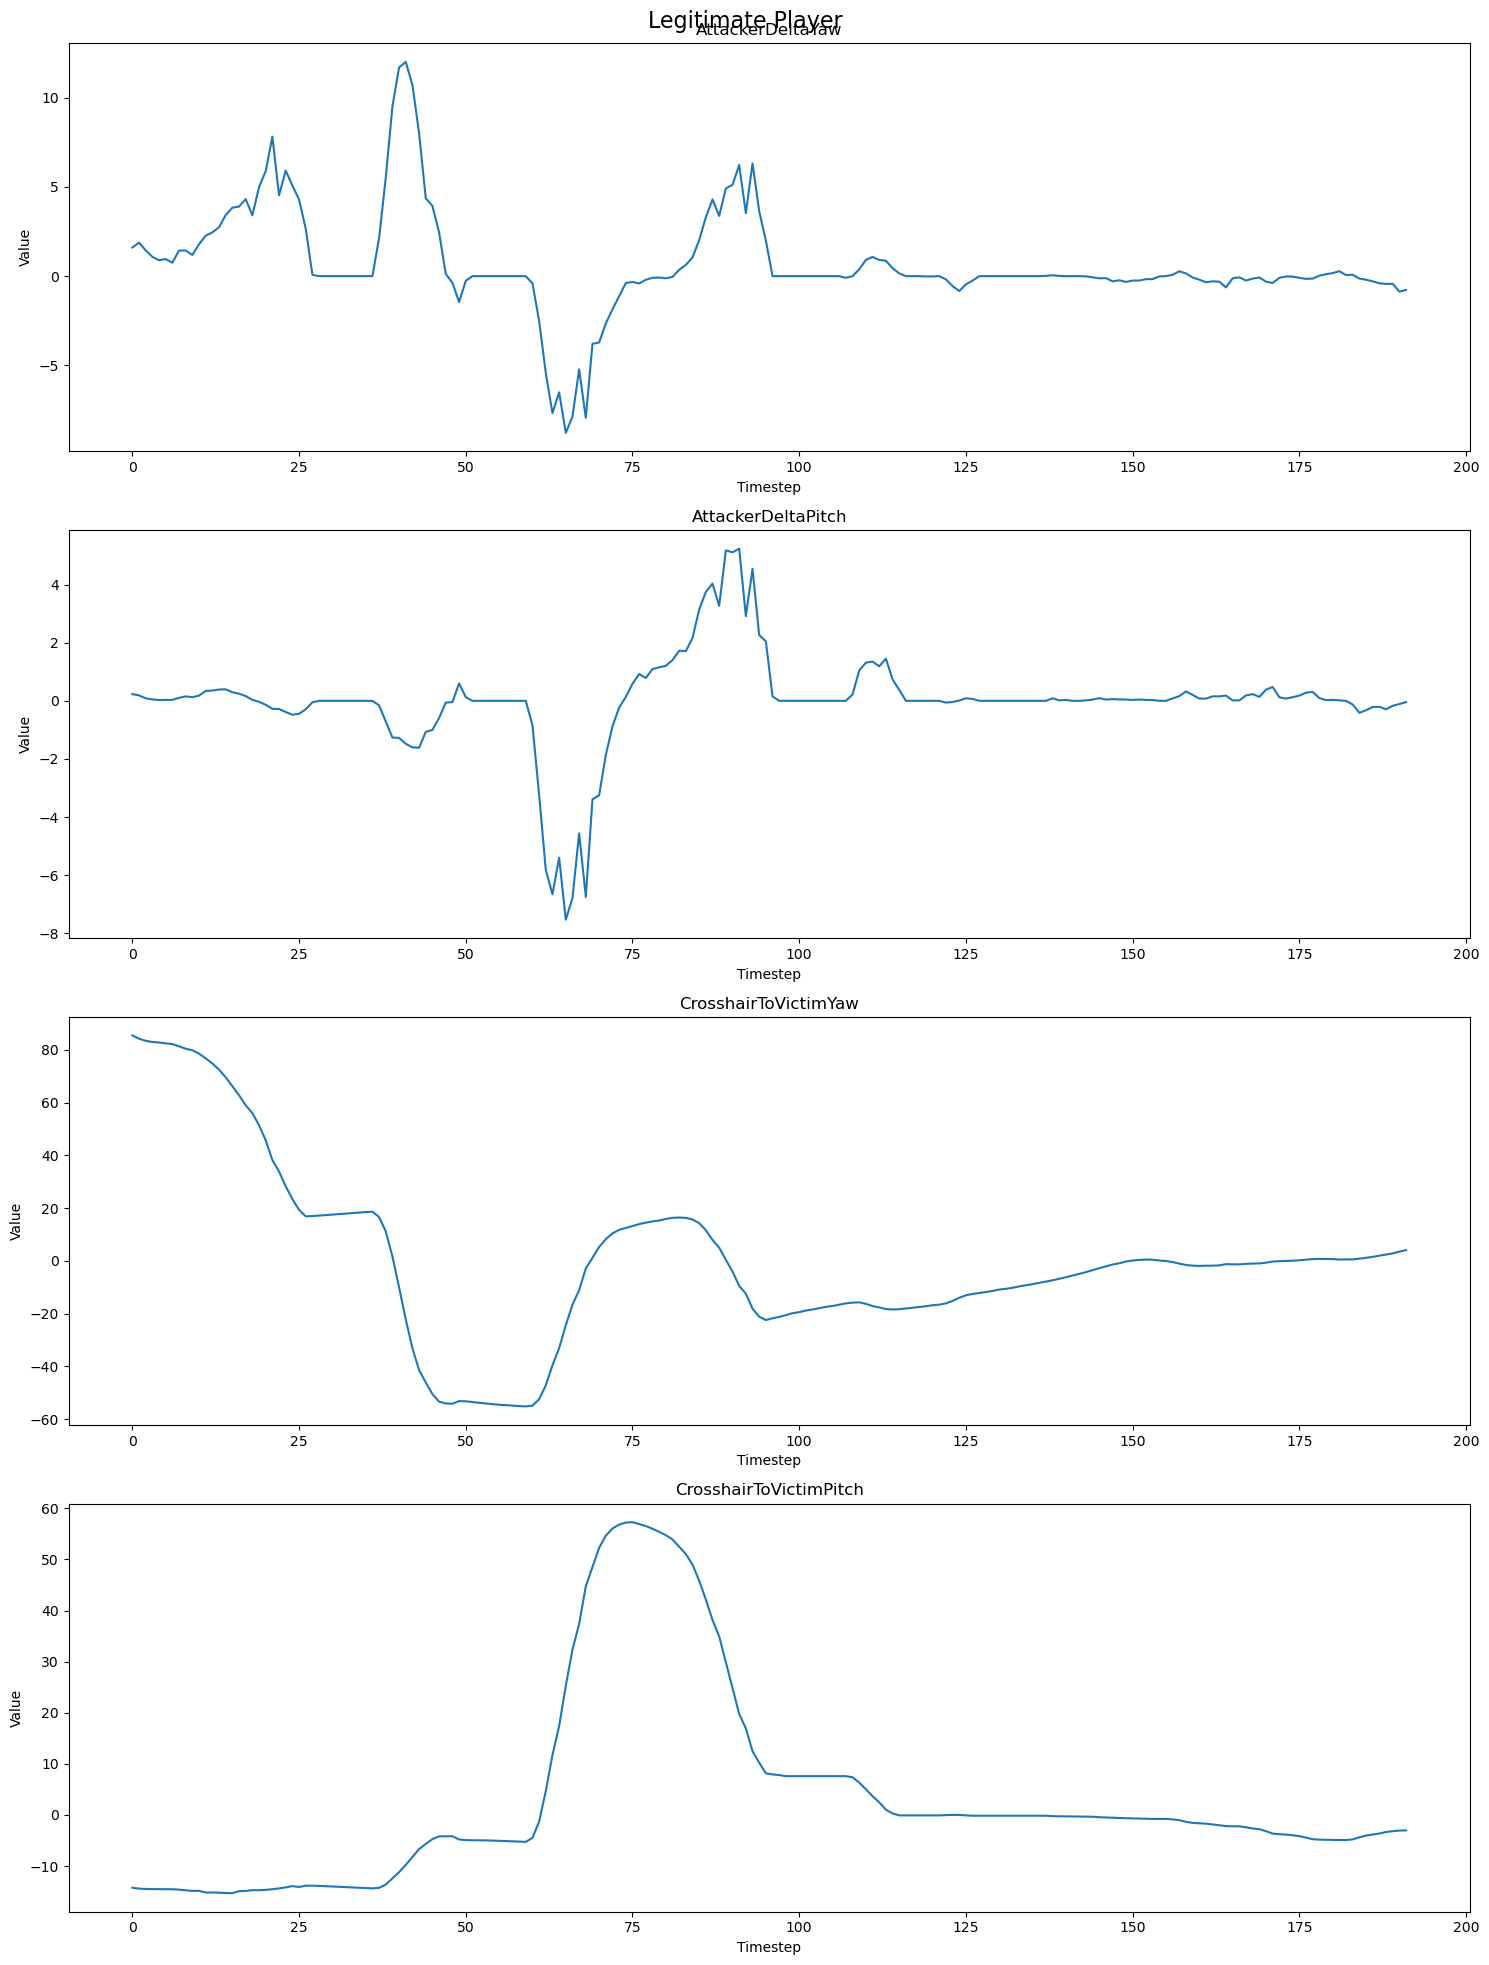

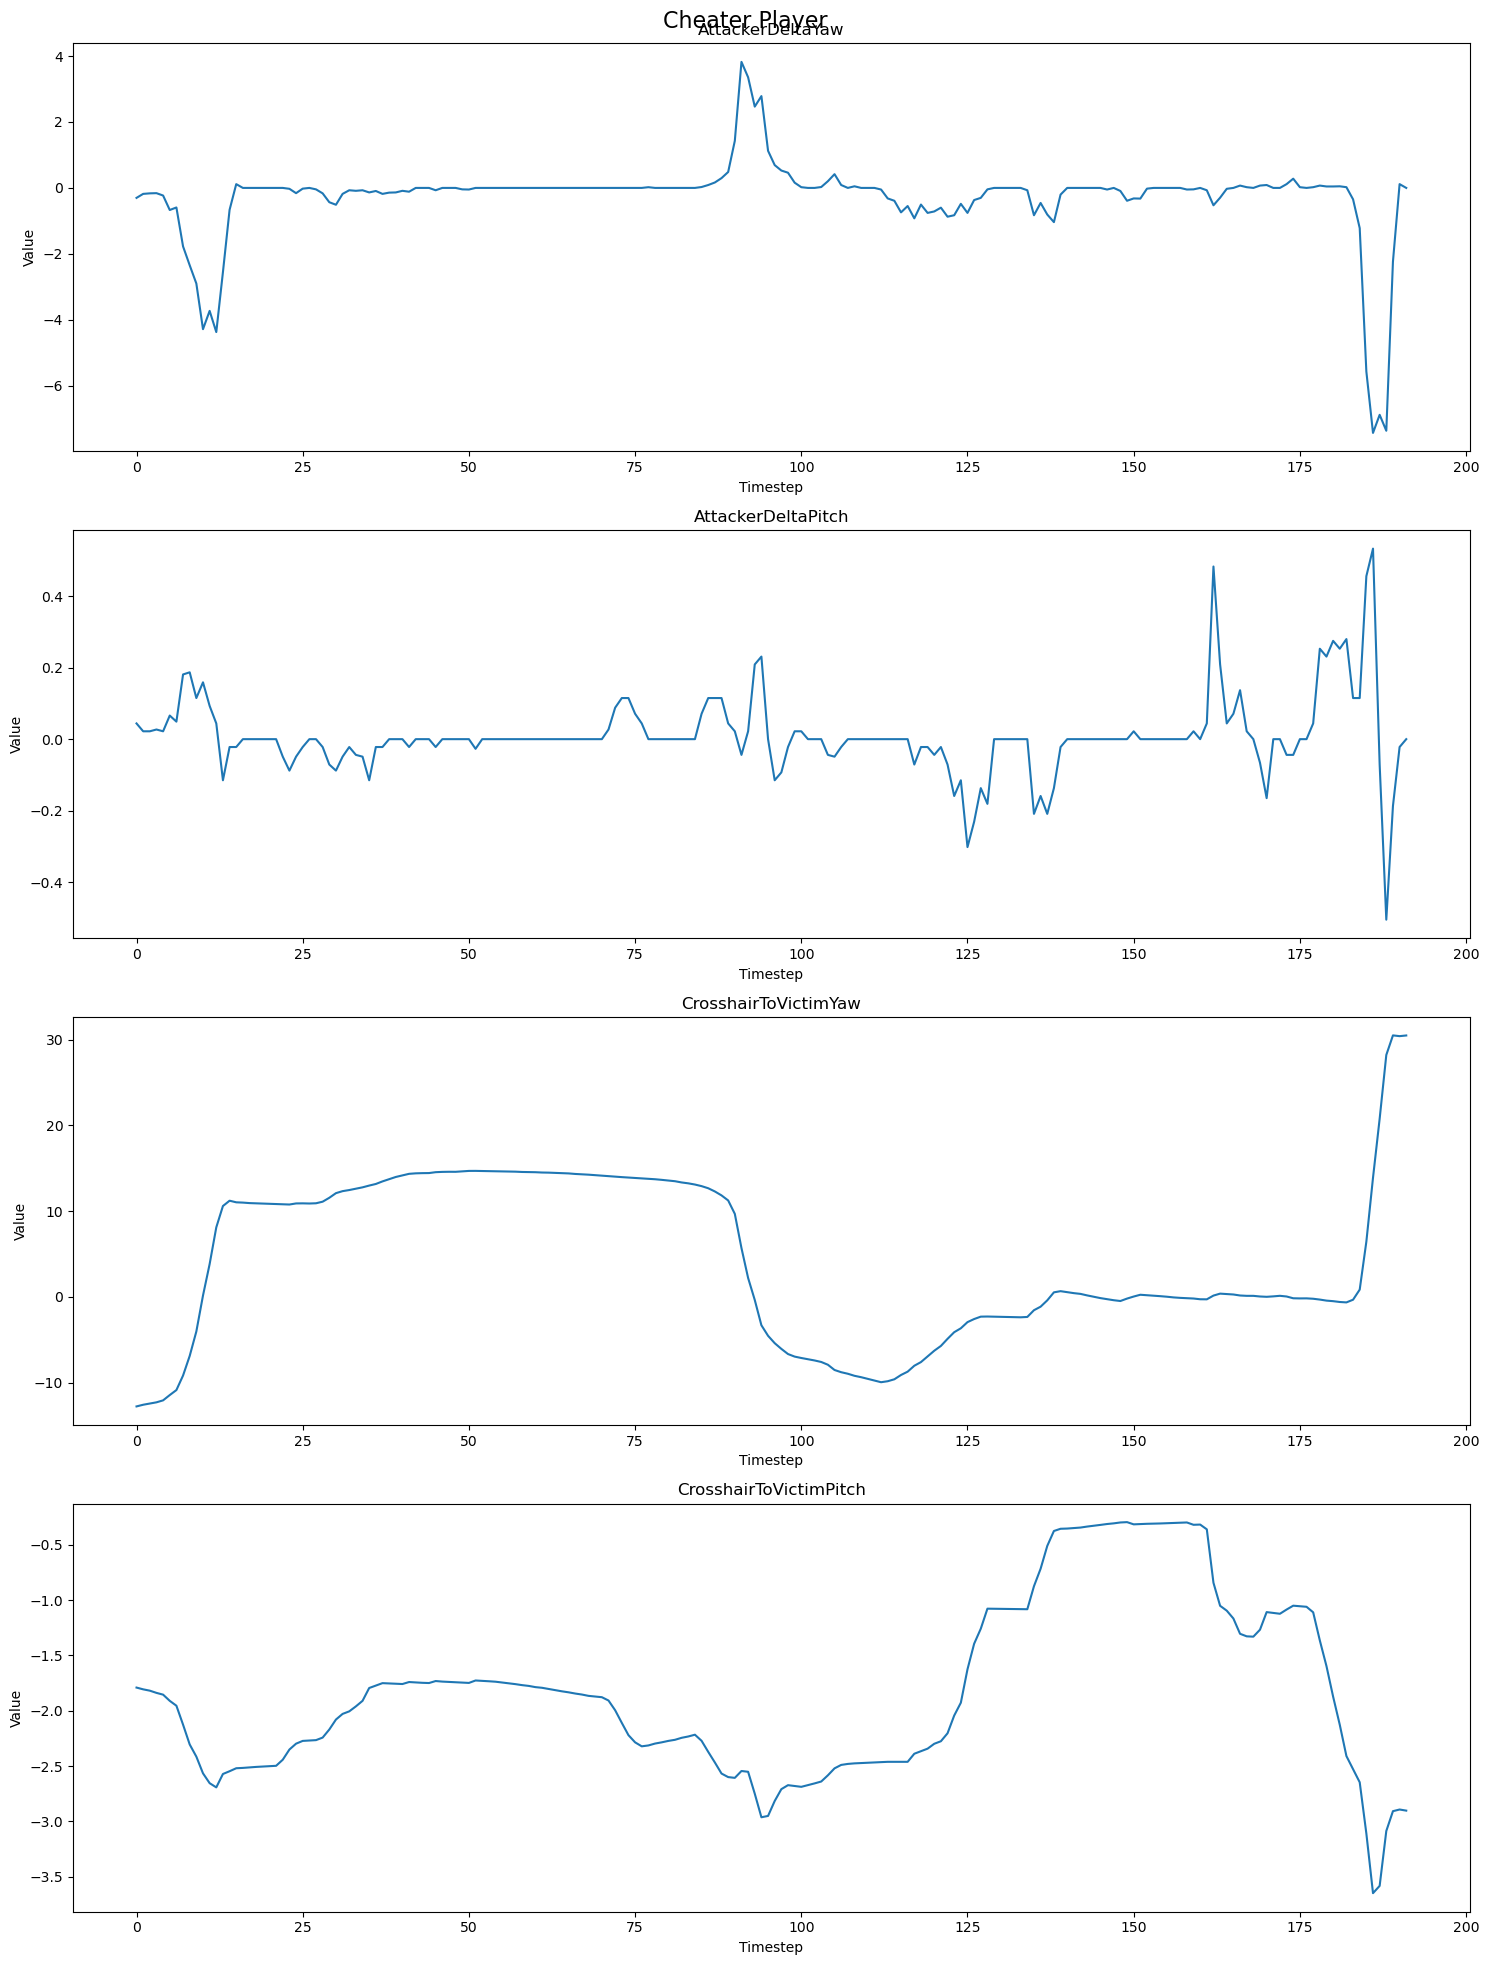

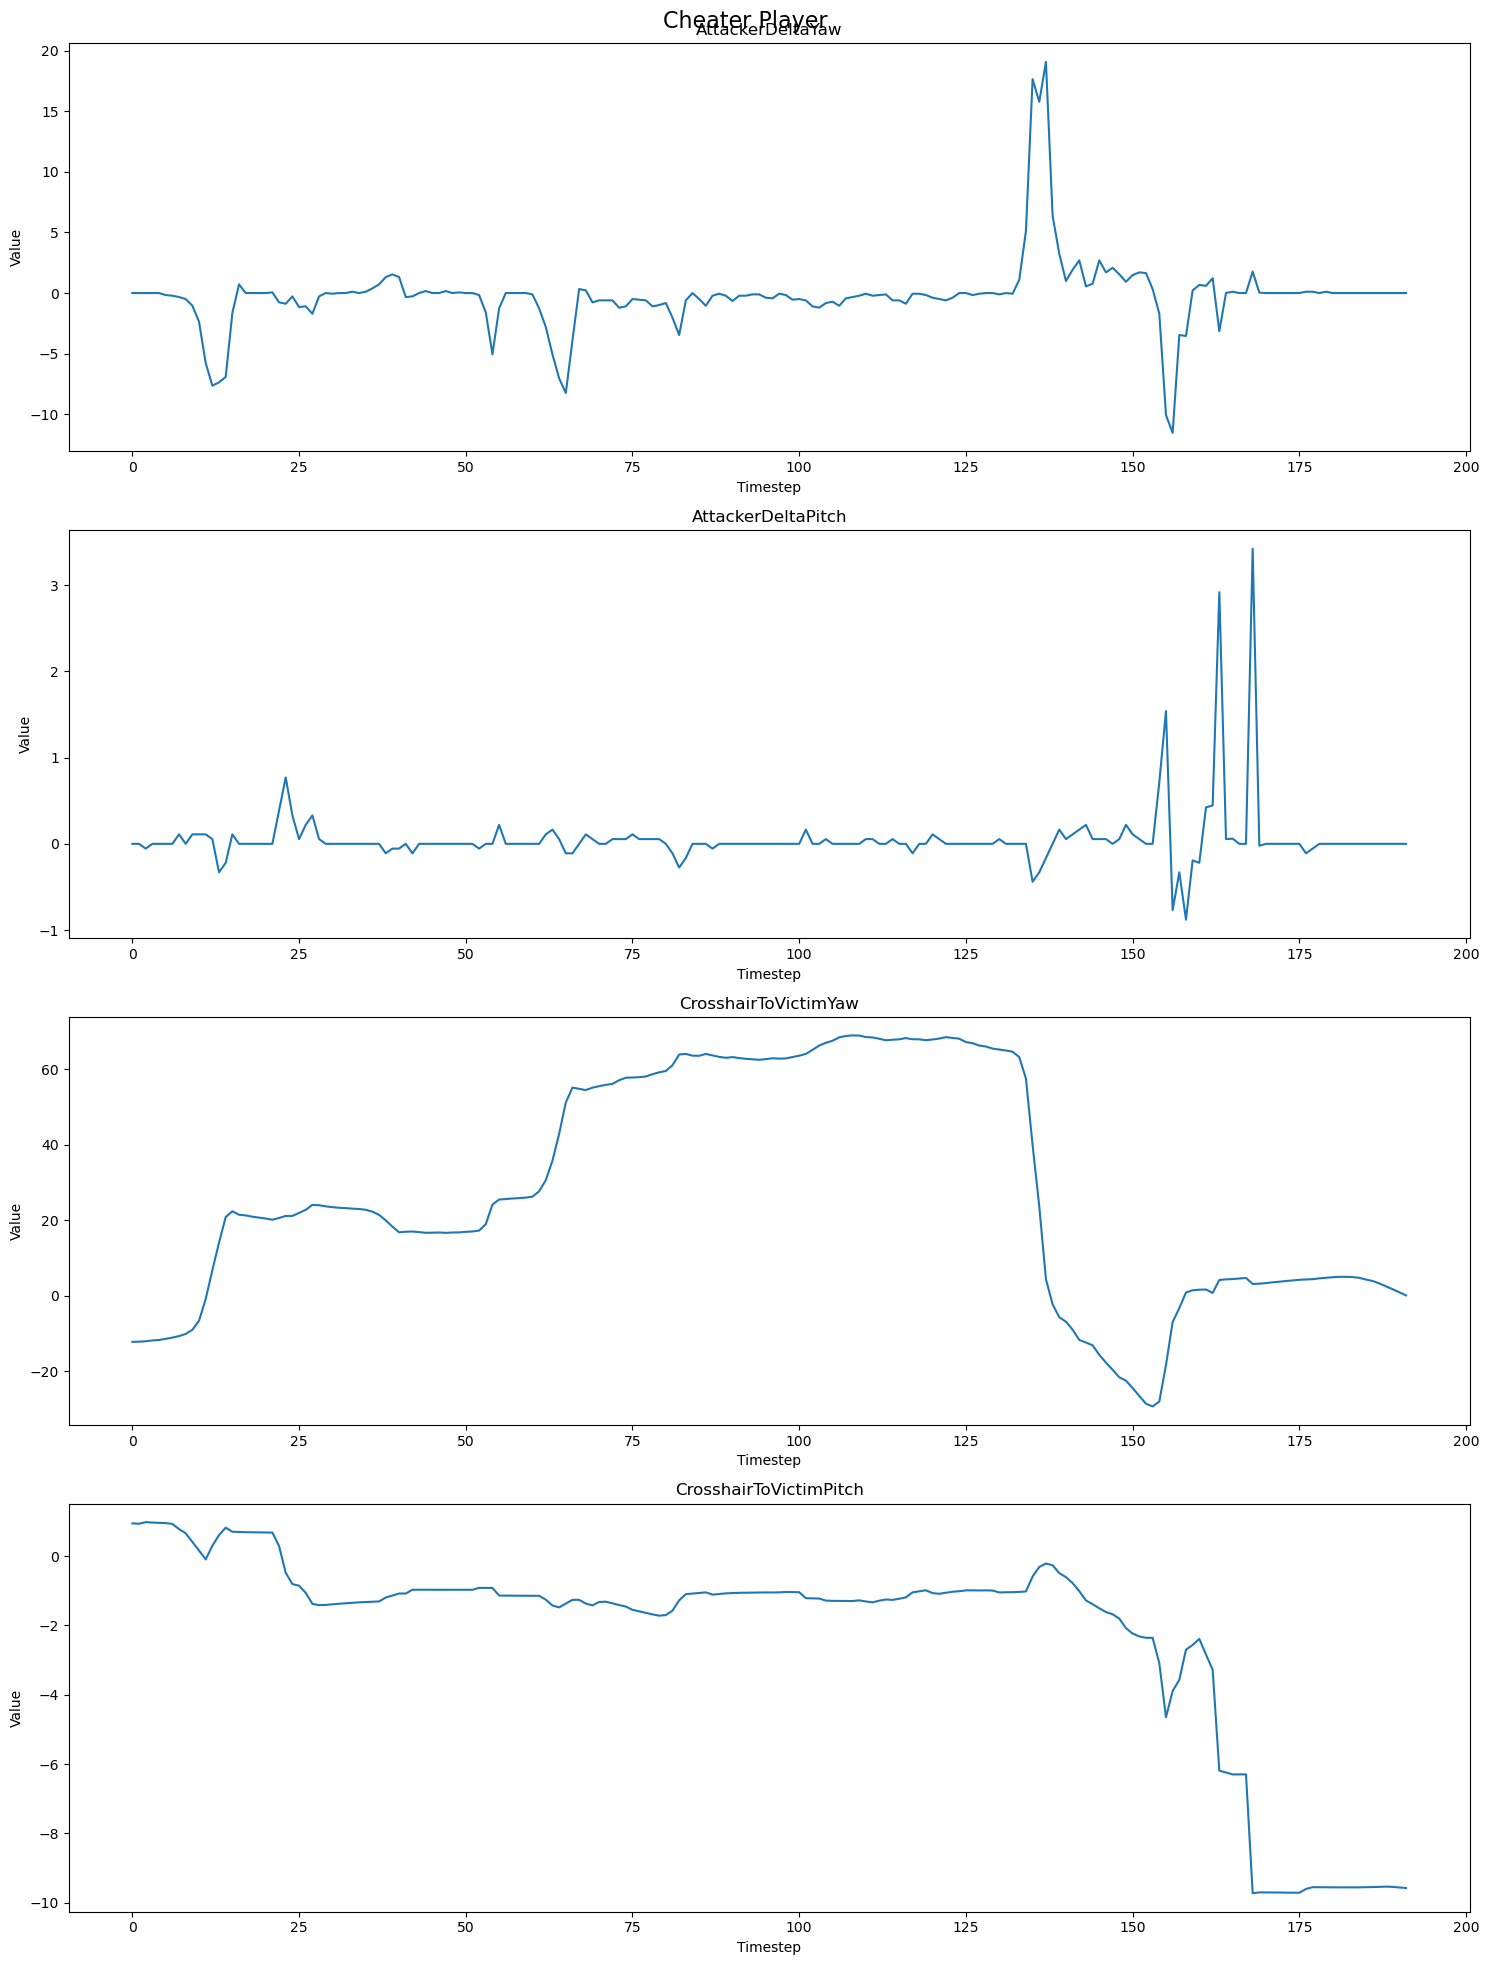

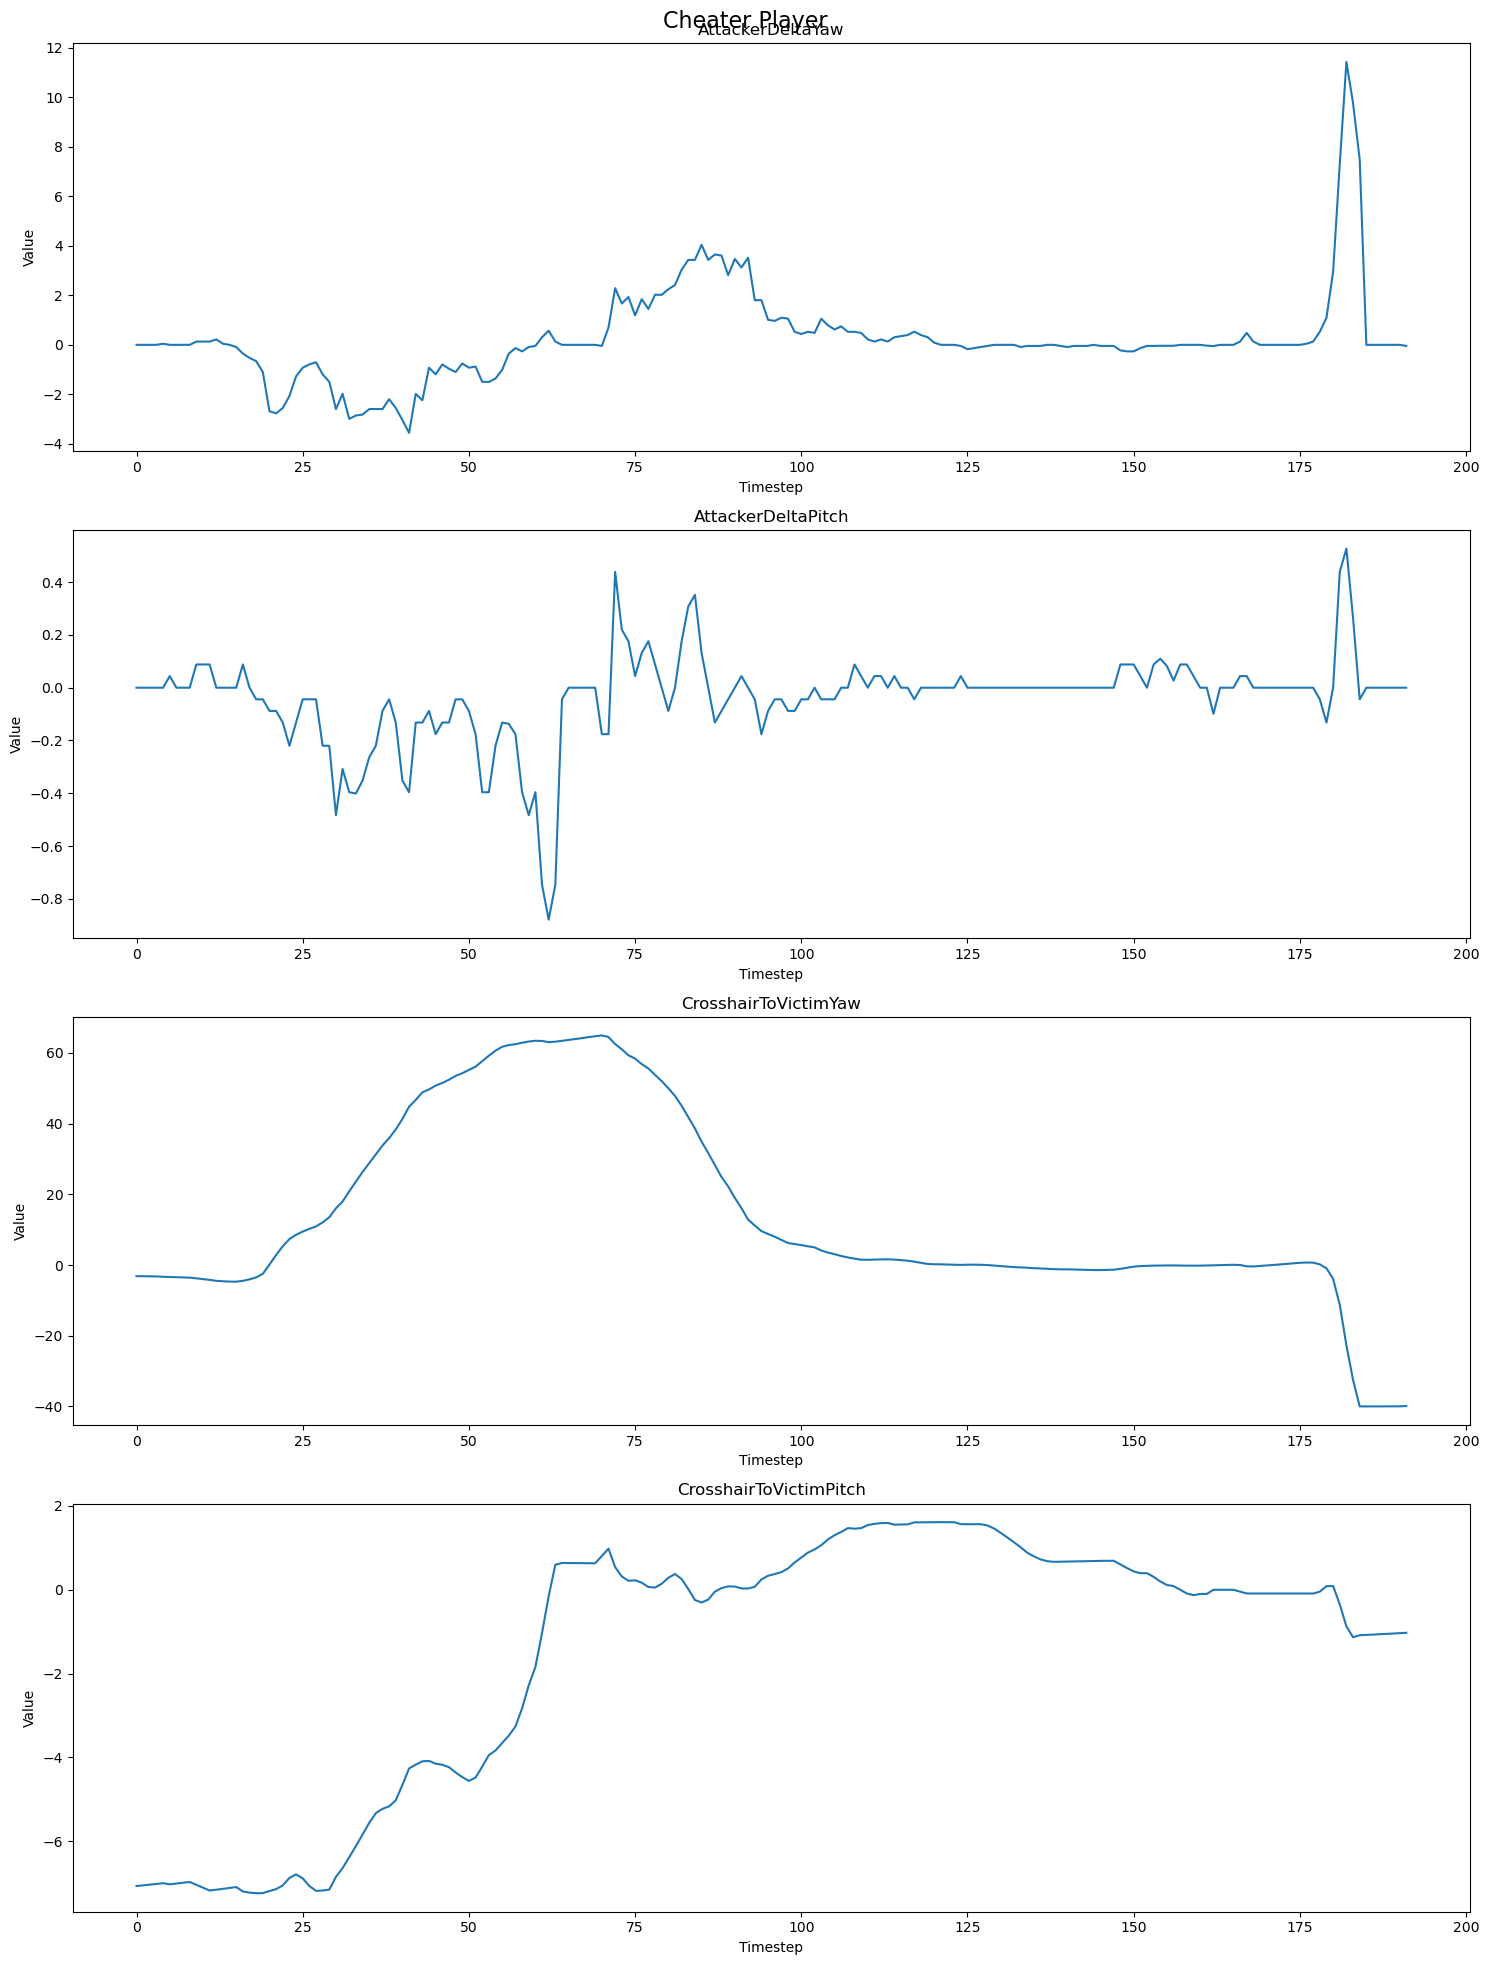

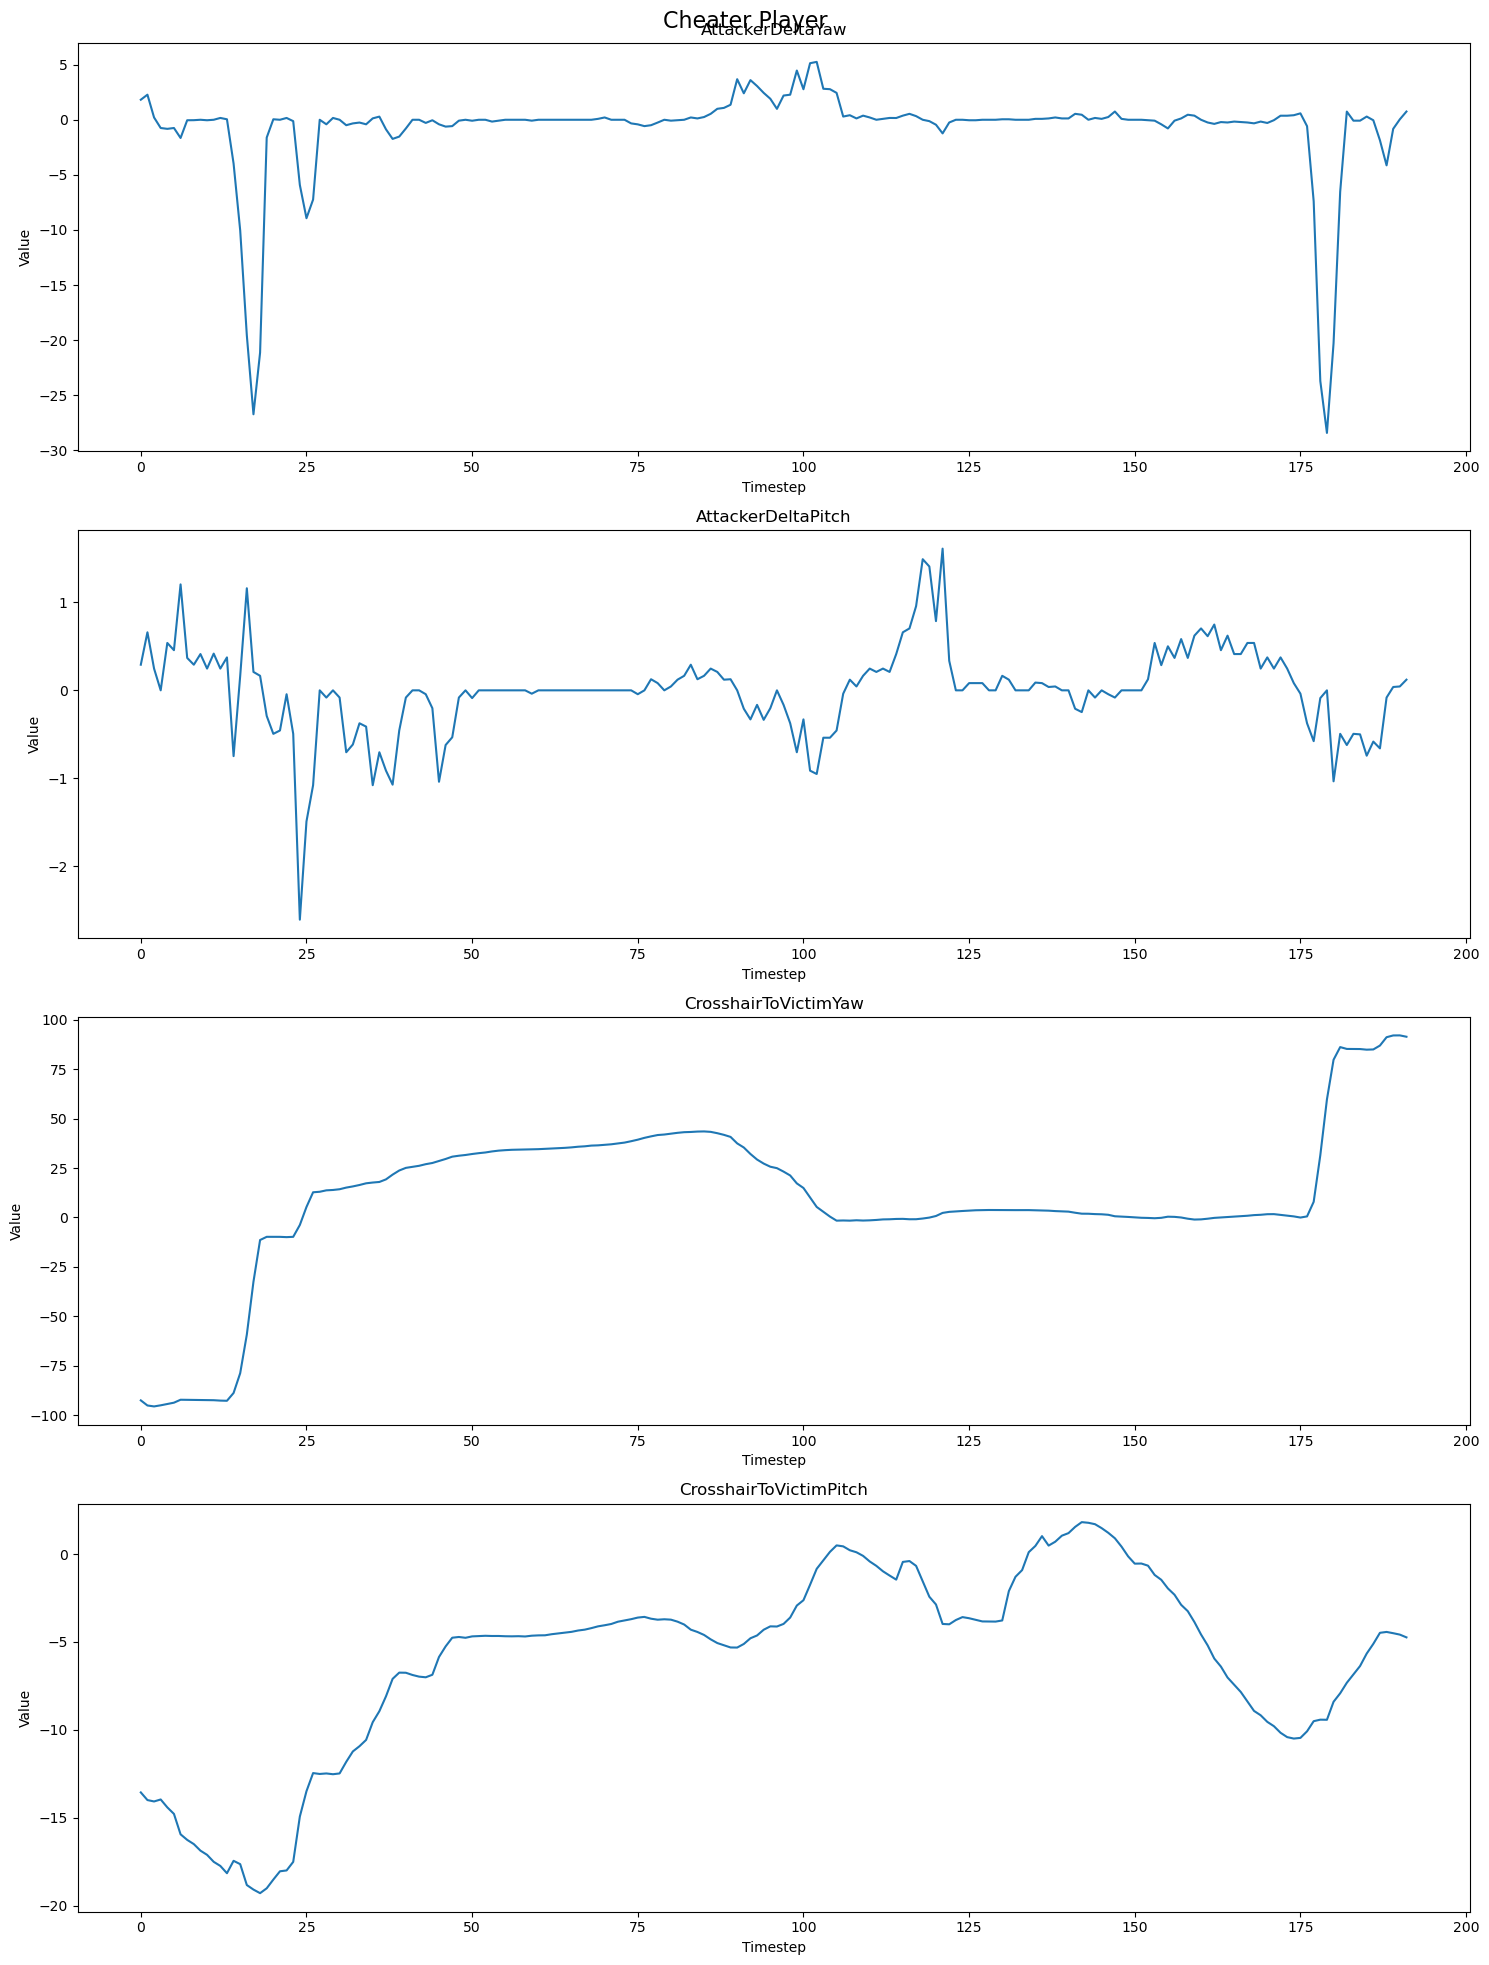

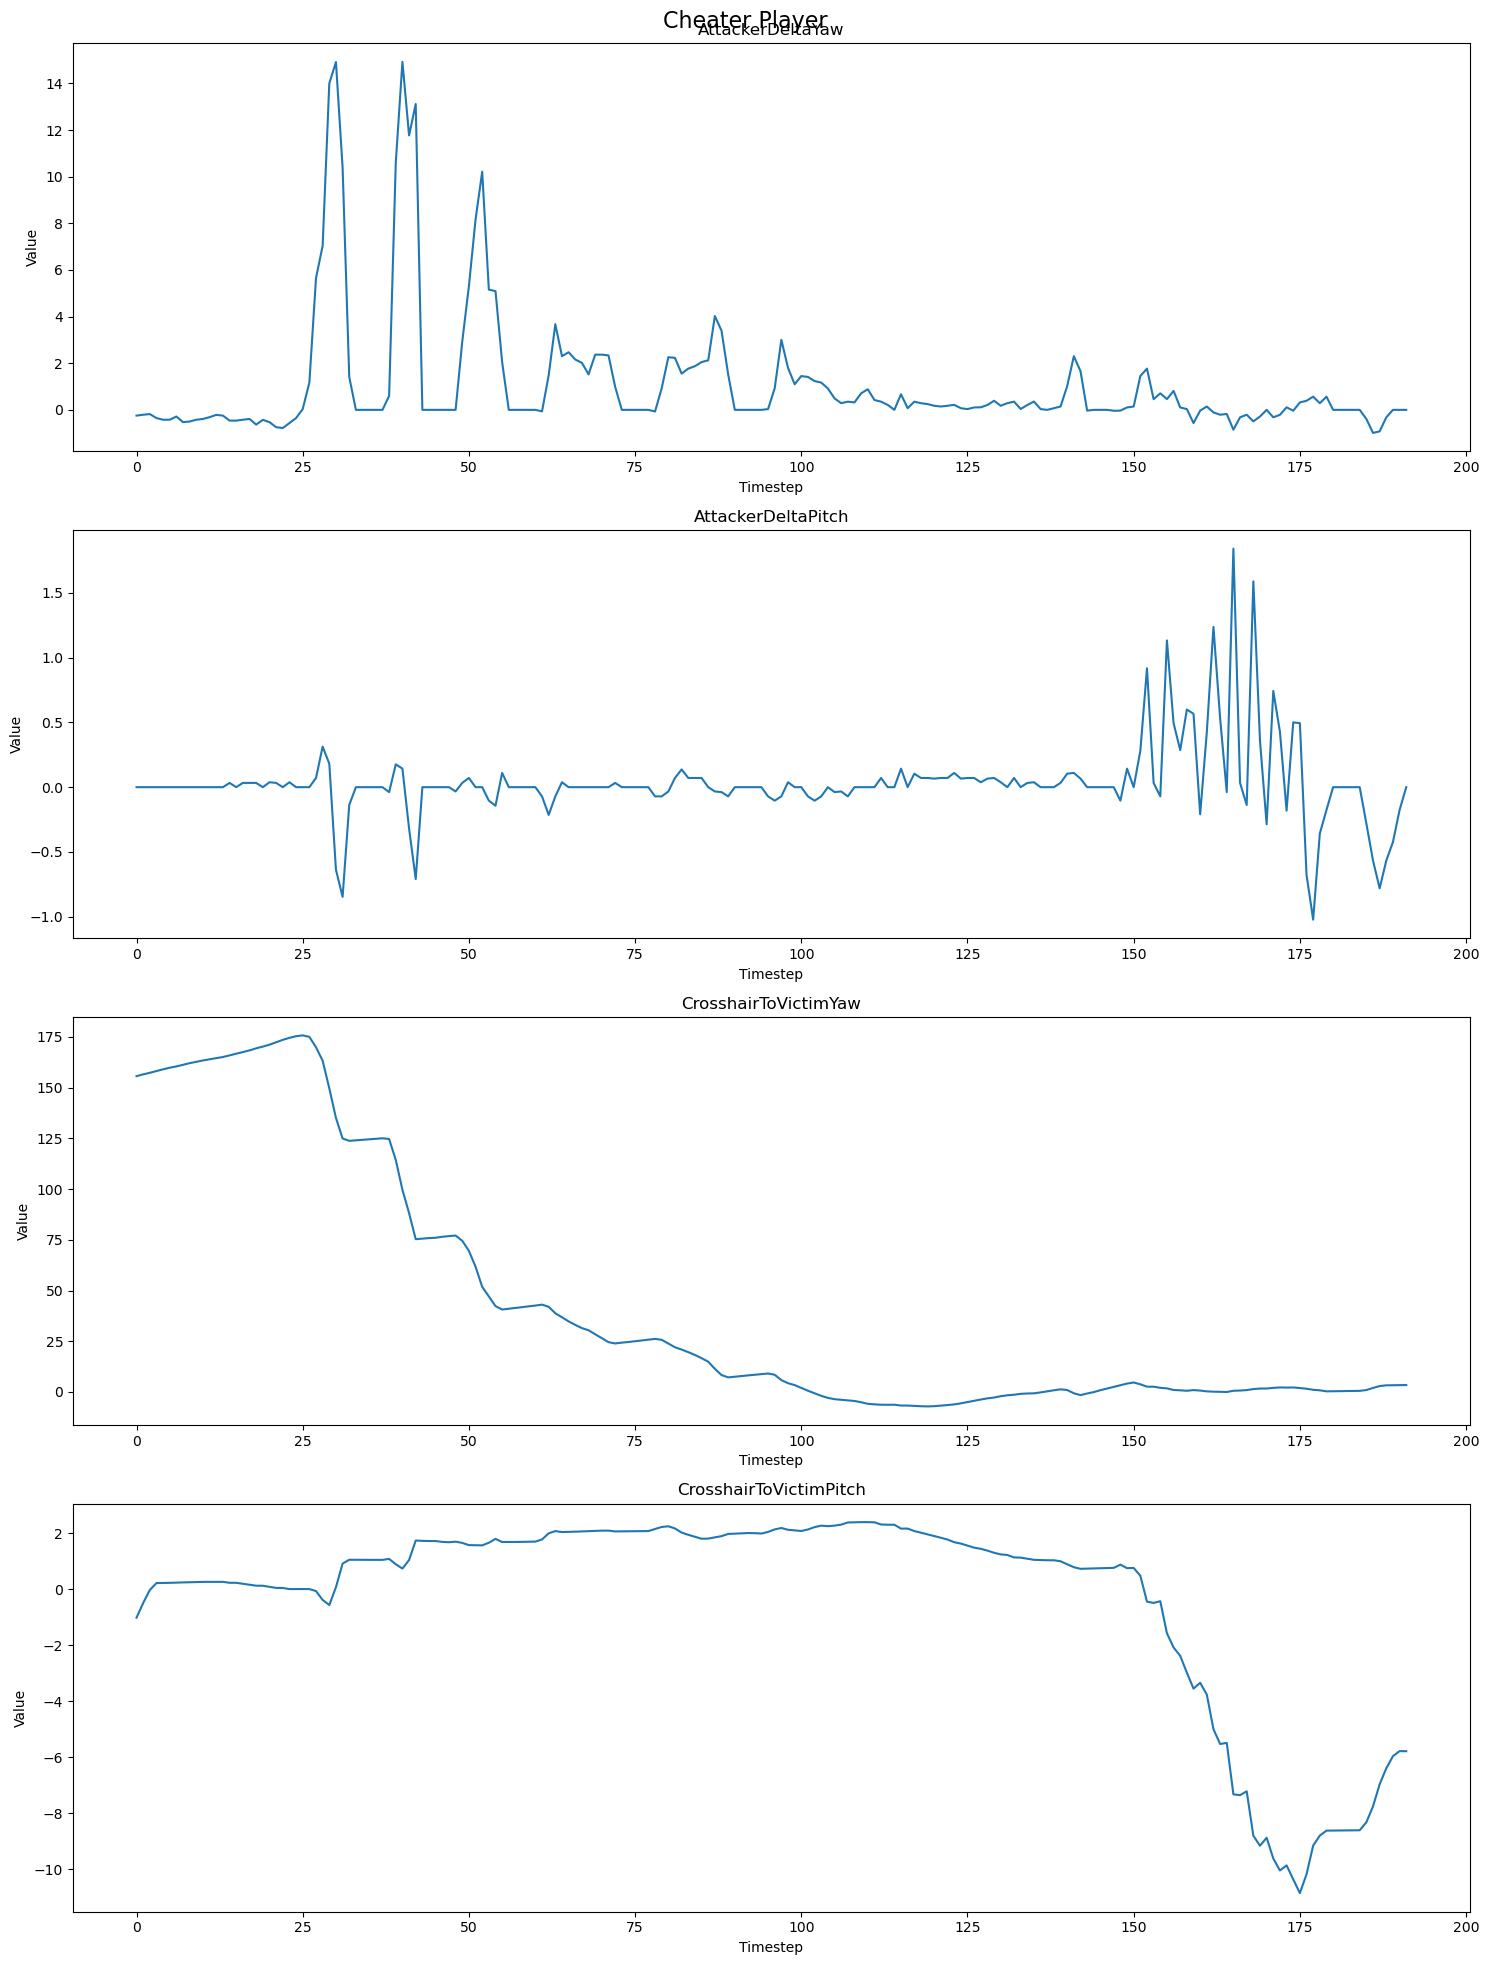

In [6]:
from scipy.stats import zscore

def plot_engagement_features(data, player_index, engagement_index, title):
    engagement = data[player_index, engagement_index]
    features = ['AttackerDeltaYaw', 'AttackerDeltaPitch', 'CrosshairToVictimYaw', 'CrosshairToVictimPitch']
    
    fig, axs = plt.subplots(4, 1, figsize=(15, 20))
    fig.suptitle(title, fontsize=16)
    
    for i, feature in enumerate(features):
        axs[i].plot(engagement[:, i])
        axs[i].set_title(feature)
        axs[i].set_xlabel('Timestep')
        axs[i].set_ylabel('Value')
    
    plt.tight_layout()
    plt.show()

def calculate_sudden_movements(data, threshold=3):
    # Calculate z-scores for each feature
    z_scores = zscore(data, axis=0)
    
    # Count sudden movements (z-score > threshold) # threshold of 3 has potential for experimentation. 
    sudden_movements = np.sum(np.abs(z_scores) > threshold, axis=0)
    
    return sudden_movements

# Sample and plot engagements
n_samples = 5
for is_cheater, data in [(0, legit_data), (1, cheaters_data)]:
    for _ in range(n_samples):
        player = np.random.randint(data.shape[0])
        engagement = np.random.randint(data.shape[1])
        plot_engagement_features(data, player, engagement, f"{'Cheater' if is_cheater else 'Legitimate'} Player")

# Analyze sudden movements
cheater_sudden_movements = []
legit_sudden_movements = []

for data, movements_list in [(cheaters_data, cheater_sudden_movements), (legit_data, legit_sudden_movements)]:
    for player in range(data.shape[0]):
        for engagement in range(data.shape[1]):
            movements_list.append(calculate_sudden_movements(data[player, engagement]))

cheater_sudden_movements = np.array(cheater_sudden_movements)
legit_sudden_movements = np.array(legit_sudden_movements)

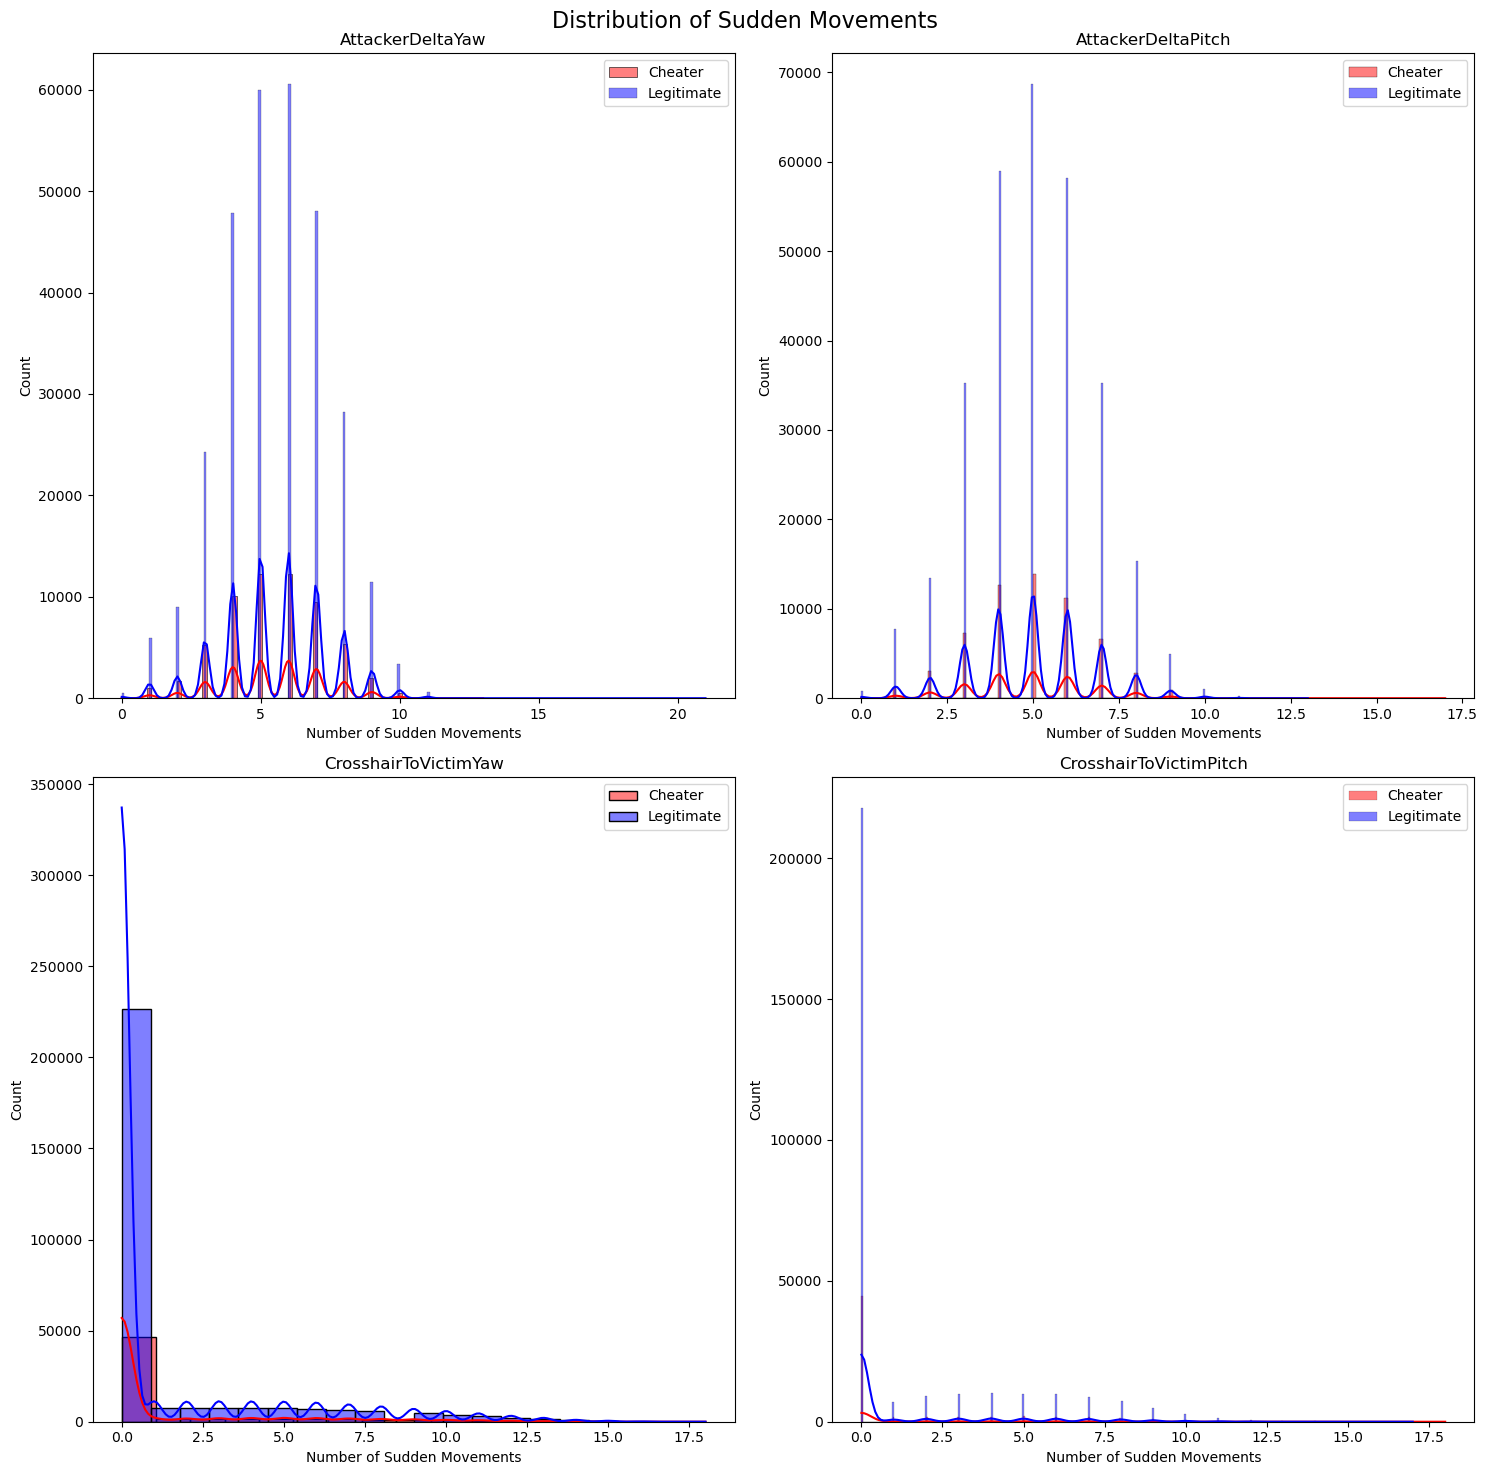

In [7]:
# Plot distribution of sudden movements
features = ['AttackerDeltaYaw', 'AttackerDeltaPitch', 'CrosshairToVictimYaw', 'CrosshairToVictimPitch']
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Distribution of Sudden Movements', fontsize=16)


for i, feature in enumerate(features):
    ax = axs[i // 2, i % 2]
    sns.histplot(cheater_sudden_movements[:, i], kde=True, ax=ax, label='Cheater', color='red', alpha=0.5)
    sns.histplot(legit_sudden_movements[:, i], kde=True, ax=ax, label='Legitimate', color='blue', alpha=0.5)
    ax.set_title(feature)
    ax.set_xlabel('Number of Sudden Movements')
    ax.set_ylabel('Count')
    ax.legend()
    
plt.tight_layout()
plt.show()


In [8]:
# Print summary statistics
print("Average number of sudden movements per engagement:")
print("Cheaters:")
print(cheater_sudden_movements.mean(axis=0))
print("\nLegitimate Players:")
print(legit_sudden_movements.mean(axis=0))

Average number of sudden movements per engagement:
Cheaters:
[5.46686667 4.91868333 1.45416667 1.29345    8.16511667]

Legitimate Players:
[5.52567333 4.98778    1.41289667 1.41431667 8.44439   ]


### Claude's interpretation of the engagement feature plots:

#### AttackerDeltaYaw:

* Legitimate players: Show more gradual changes with occasional spikes.
* Cheaters: Exhibit more abrupt, larger spikes, particularly noticeable in Image 3.


#### AttackerDeltaPitch:

* Legitimate players: Display smoother, less dramatic changes.
* Cheaters: Show more sudden, sharp changes, especially evident in Image 2.


#### CrosshairToVictimYaw:

* Legitimate players: Generally have smoother, more gradual changes.
* Cheaters: Display more abrupt changes and larger jumps, particularly in Image 3.


#### CrosshairToVictimPitch:

* Legitimate players: Show more consistent, gradual movements.
* Cheaters: Exhibit more erratic patterns with sudden large changes.



### Key observations:

* Cheaters tend to have more sudden, large-magnitude changes in their aiming behavior, which is consistent with the use of aim assistance tools.
* Legitimate players generally show smoother, more human-like patterns in their aiming and crosshair movements.
* The CrosshairToVictim measurements for cheaters often show more dramatic shifts, suggesting rapid snapping to targets.
* Cheaters' plots often have periods of very little movement followed by sudden, large changes, which could indicate toggling cheats on and off.

These observations support our initial hypothesis about cheaters exhibiting more sudden, precise movements. However, it's important to note that there's still variability within each group, and some patterns might overlap between cheaters and skilled legitimate players.

For our feature engineering, we might consider:

* Measuring the frequency and magnitude of sudden changes in each variable.
* Calculating the correlation between AttackerDelta and CrosshairToVictim variables.
* Identifying periods of low variability followed by high variability.
* Quantifying the smoothness of the aiming trajectories.

### Claude's interpretation of the sudden movements plots:

#### Distribution of Sudden Movements:

a) AttackerDeltaYaw and AttackerDeltaPitch:

* The distributions for cheaters and legitimate players are very similar.
* Both groups show a peak at around 5-6 sudden movements per engagement.
* There's a slight tendency for legitimate players to have more engagements with a higher number of sudden movements.

b) CrosshairToVictimYaw and CrosshairToVictimPitch:

* These show a more pronounced difference between cheaters and legitimate players.
* Both groups have a high peak at 0-1 sudden movements, but legitimate players have a higher peak.
* Cheaters seem to have slightly more engagements with 1-5 sudden movements in these metrics.


#### Summary Statistics:

The average number of sudden movements per engagement is surprisingly similar between cheaters and legitimate players:

* AttackerDeltaYaw: Cheaters (5.47) vs Legitimate (5.53)
* AttackerDeltaPitch: Cheaters (4.92) vs Legitimate (4.99)
* CrosshairToVictimYaw: Cheaters (1.45) vs Legitimate (1.41)
* CrosshairToVictimPitch: Cheaters (1.29) vs Legitimate (1.41)
* Firing: Cheaters (8.17) vs Legitimate (8.44)



### Key Observations:

* The differences in sudden movements between cheaters and legitimate players are more subtle than we might have expected.
* Legitimate players actually show slightly more sudden movements on average, particularly in AttackerDelta measurements.
* Cheaters show slightly fewer sudden movements in CrosshairToVictim measurements, which is contrary to our initial expectations.
* The firing patterns (last column in the summary statistics) show that legitimate players fire slightly more often than cheaters.

These findings suggest that simply counting the number of sudden movements may not be sufficient to distinguish cheaters from skilled legitimate players. We need to consider more nuanced features that capture the quality and context of these movements, rather than just their quantity.

Given these insights, here are some refined ideas for feature engineering:

* Contextual sudden movements: Analyze sudden movements in relation to game events (e.g., when enemies appear, when shots are fired).
* Precision of movements: Measure how accurately sudden movements align with enemy positions.
* Consistency of behavior: Look at the variance of sudden movements across different engagements for each player.
* Timing patterns: Analyze the timing between sudden movements and shots fired.
* Movement sequences: Examine patterns of consecutive sudden movements rather than just their overall count.

## Feature engineering

In [9]:
import itertools

def ratio_sudden_movements(data, threshold=3):
    z_scores = np.abs(zscore(data, axis=0))
    sudden_movements = np.sum(z_scores > threshold, axis=0)
    total_movements = np.sum(np.abs(data) > 0, axis=0)
    return sudden_movements / total_movements

def movement_variance(data):
    return np.var(data, axis=0)

def max_consecutive_sudden(data, threshold=3):
    z_scores = np.abs(zscore(data, axis=0))
    sudden = z_scores > threshold
    return np.array([max([len(list(group)) for key, group in itertools.groupby(col) if key], default=0) for col in sudden.T])

def crosshair_movement_correlation(data):
    return np.array([np.corrcoef(data[:, 0], data[:, 2])[0, 1],
                     np.corrcoef(data[:, 1], data[:, 3])[0, 1]])

def perfect_aim_frequency(data, precision=0.001):
    return np.sum((np.abs(data[:, 2]) < precision) & (np.abs(data[:, 3]) < precision), axis=0) / data.shape[0]

def firing_pattern(data):
    fire_times = np.where(data[:, 4] == 1)[0]
    if len(fire_times) > 1:
        return np.std(np.diff(fire_times))
    return 0

def movement_smoothness(data):
    return np.mean(np.abs(np.diff(data[:, :4], axis=0)), axis=0)

def extract_features(engagement_data):
    features = []
    features.extend(ratio_sudden_movements(engagement_data[:, :4]))
    features.extend(movement_variance(engagement_data[:, :4]))
    features.extend(max_consecutive_sudden(engagement_data[:, :4]))
    features.extend(crosshair_movement_correlation(engagement_data))
    features.append(perfect_aim_frequency(engagement_data))
    features.append(firing_pattern(engagement_data))
    features.extend(movement_smoothness(engagement_data))
    return features

# Apply to all engagements
cheater_features = np.array([extract_features(engagement) for player in cheaters_data for engagement in player])
legit_features = np.array([extract_features(engagement) for player in legit_data for engagement in player])

# Combine features and labels
X = np.vstack((cheater_features, legit_features))
y = np.hstack((np.ones(cheater_features.shape[0]), np.zeros(legit_features.shape[0])))

# Create feature names for easier interpretation
feature_names = [
    'RSM_AttackerDeltaYaw', 'RSM_AttackerDeltaPitch', 'RSM_CrosshairToVictimYaw', 'RSM_CrosshairToVictimPitch',
    'Var_AttackerDeltaYaw', 'Var_AttackerDeltaPitch', 'Var_CrosshairToVictimYaw', 'Var_CrosshairToVictimPitch',
    'MaxConsec_AttackerDeltaYaw', 'MaxConsec_AttackerDeltaPitch', 'MaxConsec_CrosshairToVictimYaw', 'MaxConsec_CrosshairToVictimPitch',
    'Corr_Yaw', 'Corr_Pitch',
    'PerfectAimFreq',
    'FiringPatternStd',
    'Smoothness_AttackerDeltaYaw', 'Smoothness_AttackerDeltaPitch', 'Smoothness_CrosshairToVictimYaw', 'Smoothness_CrosshairToVictimPitch'
]

/Users/asadm2/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/asadm2/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/asadm2/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [10]:
X

array([[0.05645161, 0.05747126, 0.        , ..., 0.06395809, 0.35026184,
        0.11616232],
       [0.04545455, 0.07142857, 0.        , ..., 0.10284292, 1.79416776,
        0.14363872],
       [0.02068966, 0.01960784, 0.        , ..., 0.27405253, 0.79824597,
        0.41115195],
       ...,
       [0.13157895, 0.0952381 , 0.        , ..., 0.04039267, 0.53261781,
        0.14654973],
       [0.02580645, 0.01398601, 0.        , ..., 0.15734029, 1.29005253,
        0.33201033],
       [0.02380952, 0.04081633, 0.        , ..., 0.04246596, 0.3069371 ,
        0.09933513]])

Now, let's analyze the distribution of these new features and assess their potential for distinguishing between cheaters and legitimate players:

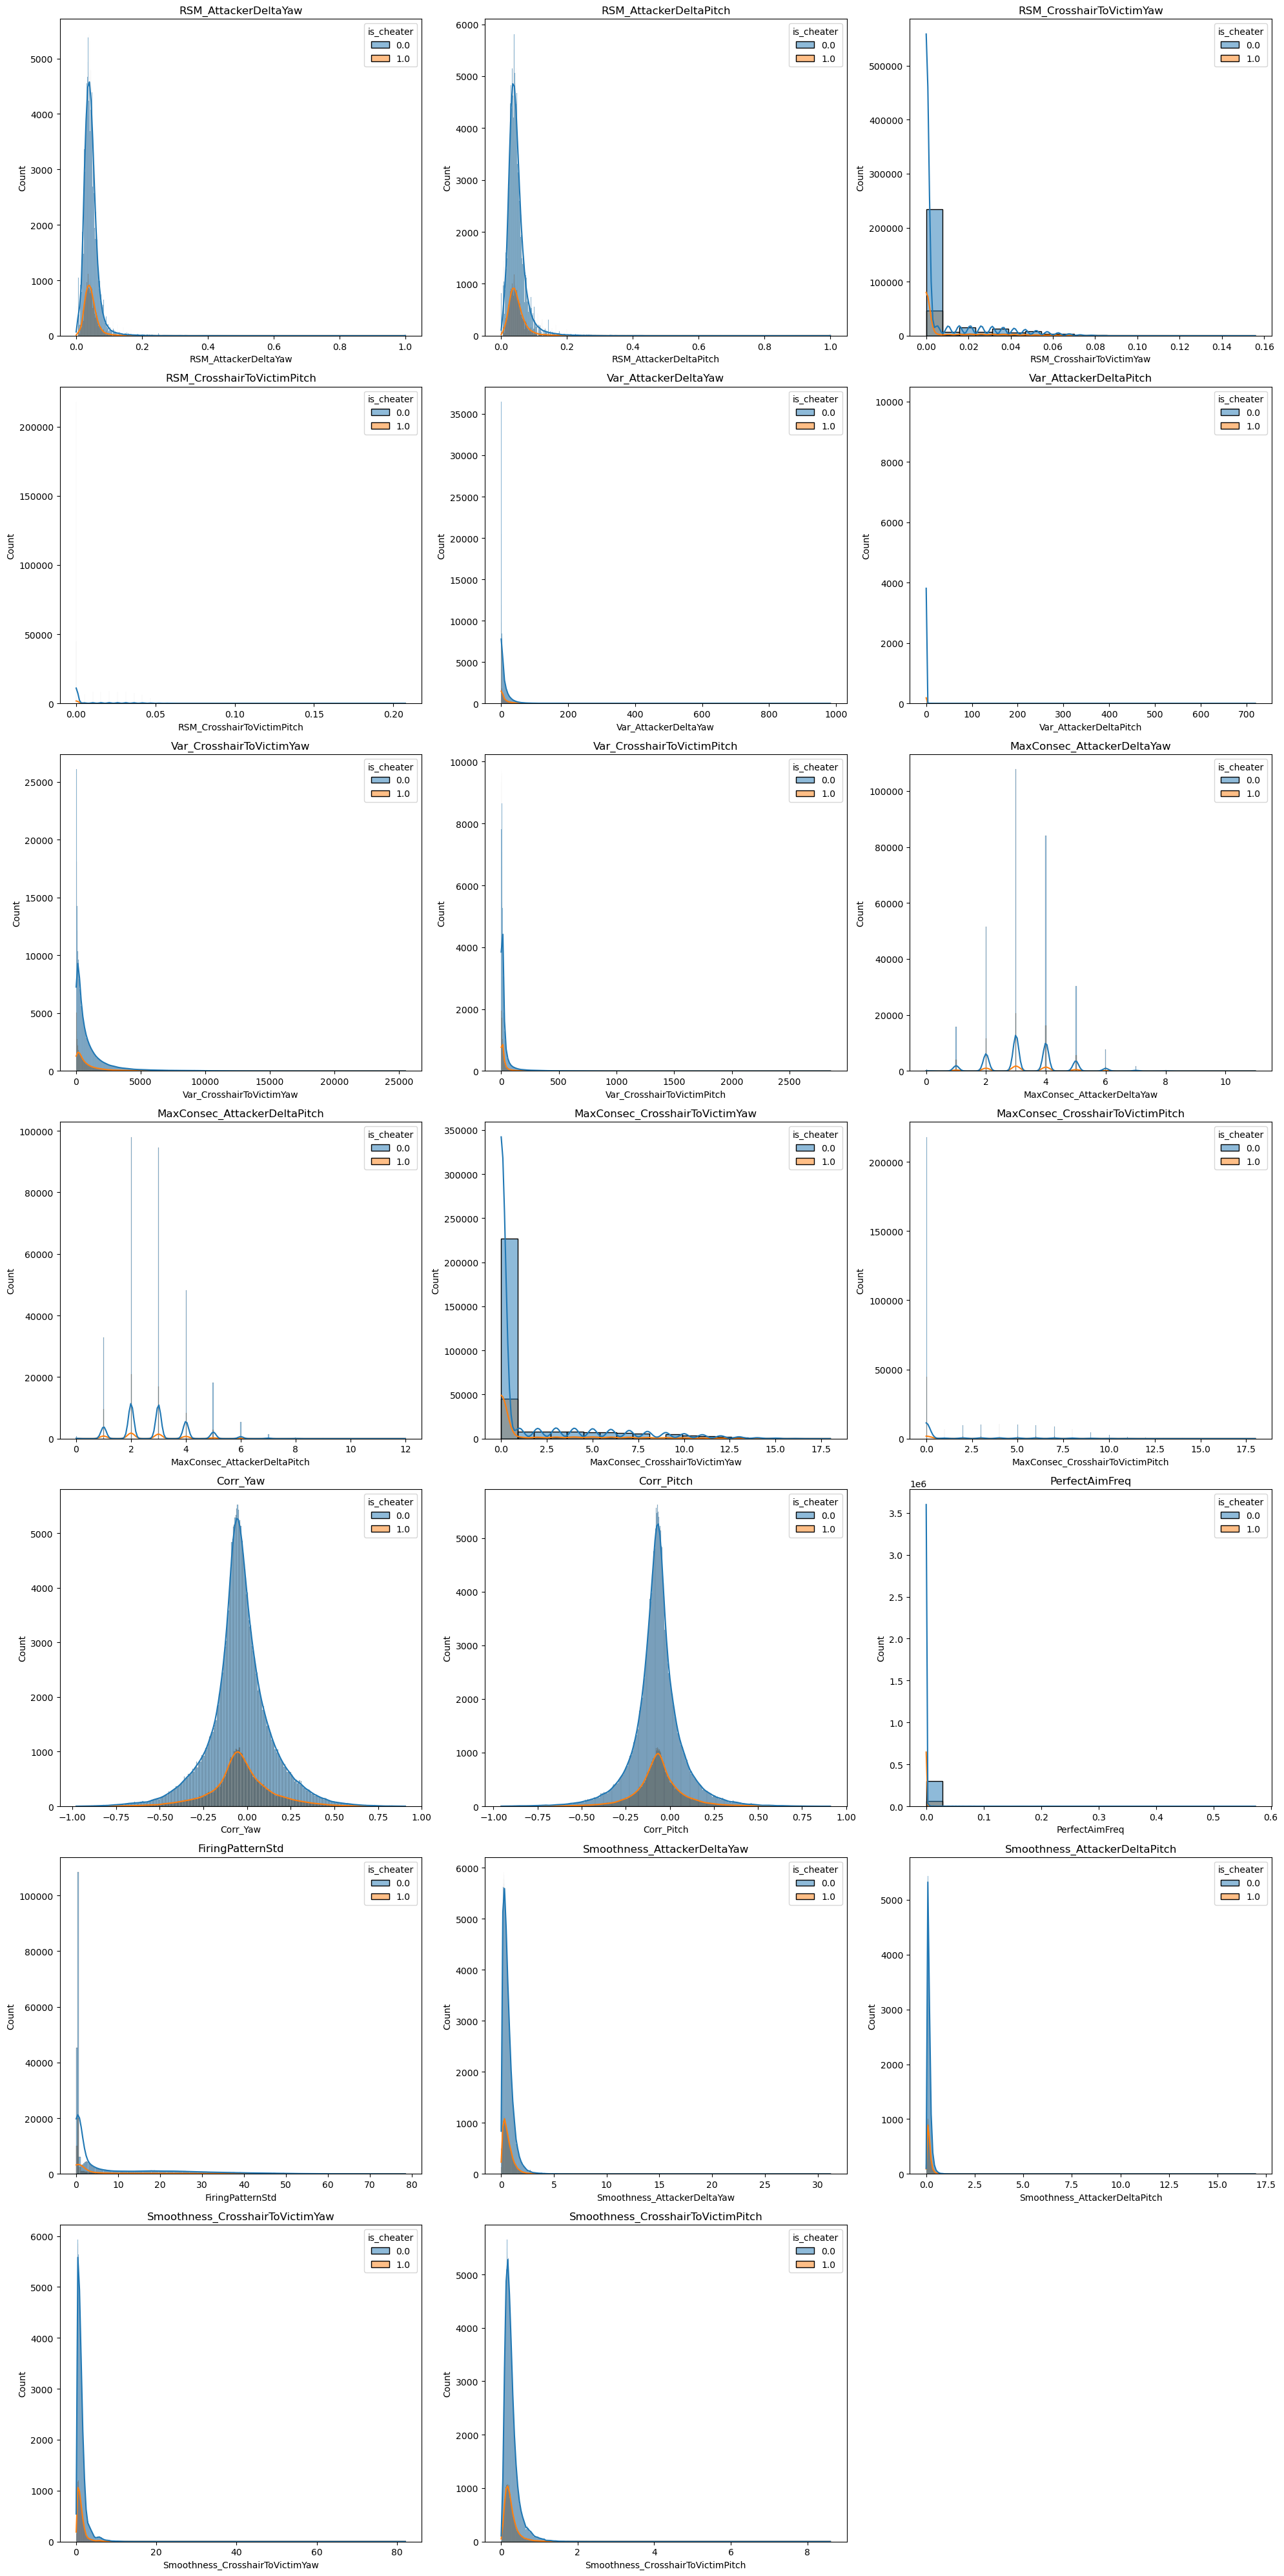

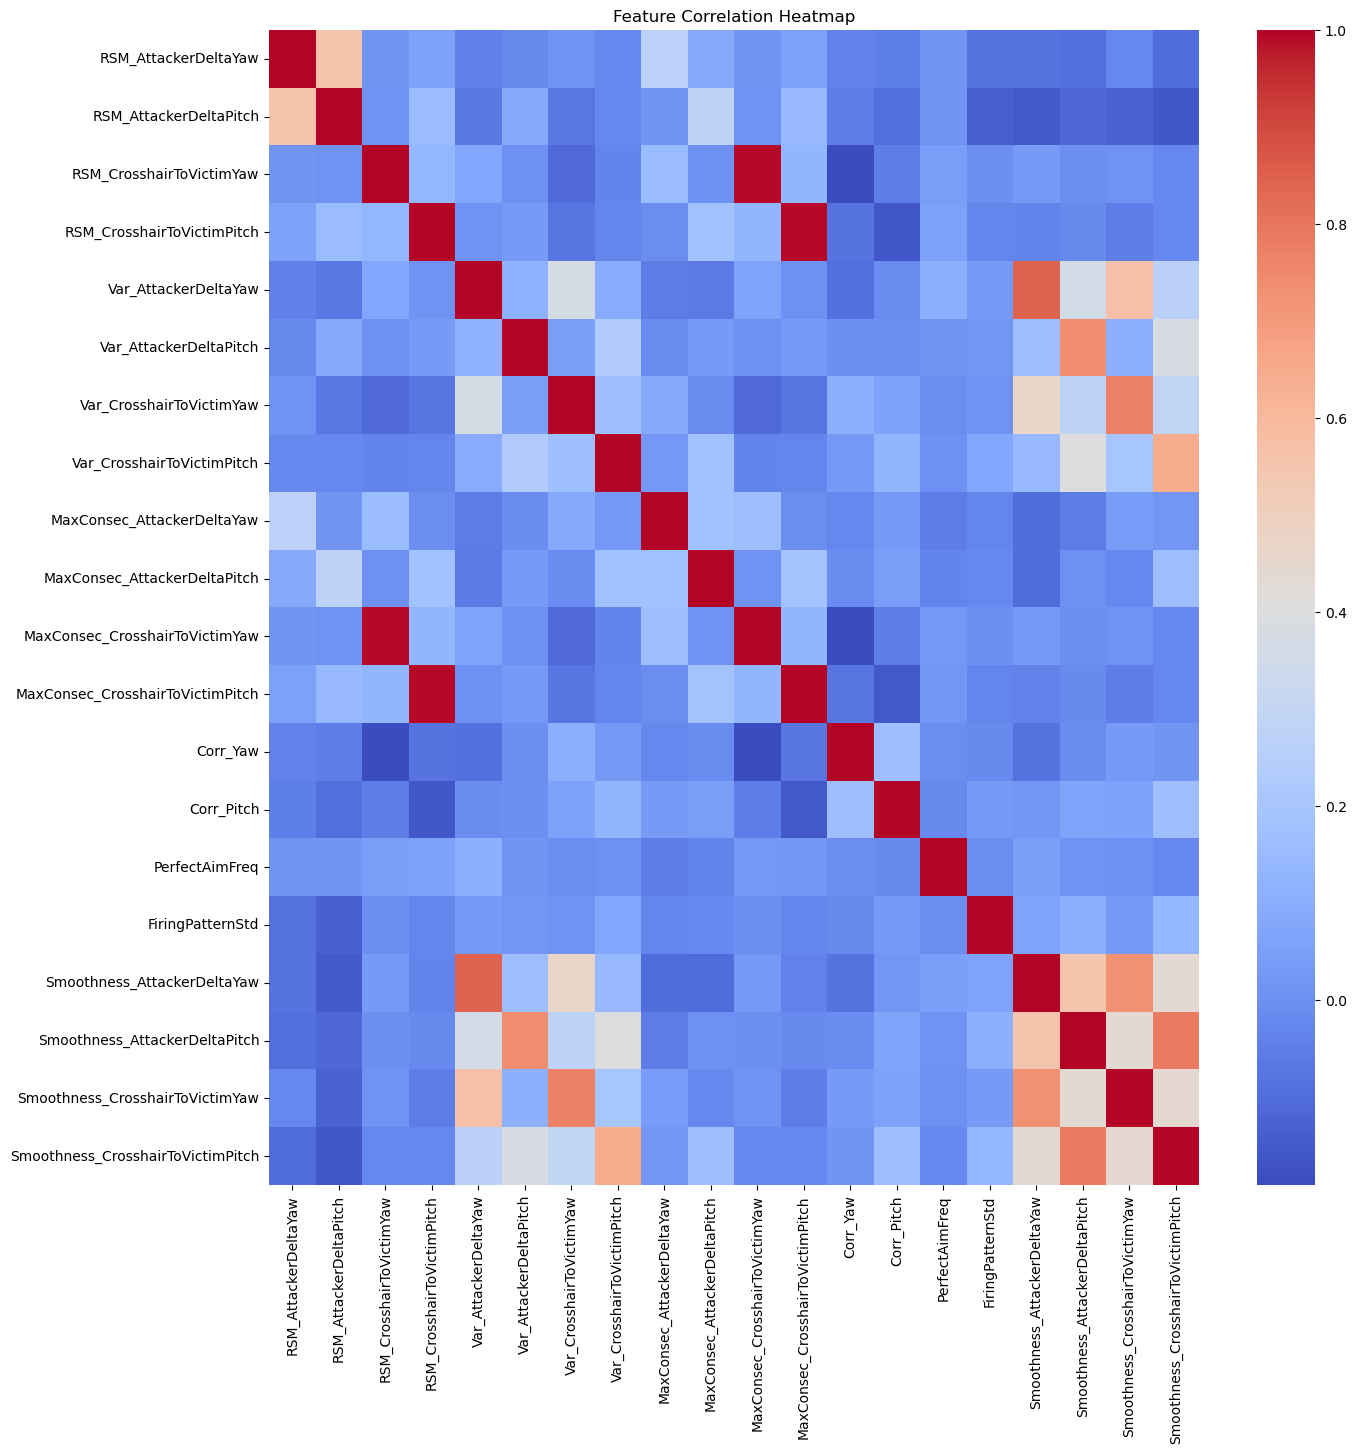

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [14]:

# Create a DataFrame for easier analysis
df = pd.DataFrame(X, columns=feature_names)
df['is_cheater'] = y

# Plot distribution of each feature
plt.figure(figsize=(20, 40))
for i, feature in enumerate(feature_names):
    plt.subplot(7, 3, i+1)
    sns.histplot(data=df, x=feature, hue='is_cheater', kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

# Compute correlation matrix
corr_matrix = df[feature_names].corr()

# Plot correlation heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Basic feature importance using logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lr = LogisticRegression(random_state=42)
lr.fit(X_scaled, y)

feature_importance = pd.DataFrame({'feature': feature_names, 'importance': np.abs(lr.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

### Identifying where NaNs/infs are in X

In [15]:
import numpy as np
import pandas as pd

# Assuming X and feature_names are defined as before
df = pd.DataFrame(X, columns=feature_names)

# Check for NaN or infinite values
print("Columns with NaN values:")
print(df.columns[df.isna().any()].tolist())

print("\nColumns with infinite values:")
print(df.columns[np.isinf(df).any()].tolist())

# Print some statistics about these columns
for col in df.columns[df.isna().any()].tolist() + df.columns[np.isinf(df).any()].tolist():
    print(f"\nStatistics for {col}:")
    print(df[col].describe())
    print(f"Number of NaNs: {df[col].isna().sum()}")
    print(f"Number of infinities: {np.isinf(df[col]).sum()}")

Columns with NaN values:
['RSM_AttackerDeltaYaw', 'RSM_AttackerDeltaPitch', 'RSM_CrosshairToVictimPitch', 'Corr_Yaw', 'Corr_Pitch']

Columns with infinite values:
[]

Statistics for RSM_AttackerDeltaYaw:
count    359987.000000
mean          0.044590
std           0.024540
min           0.000000
25%           0.031250
50%           0.041379
75%           0.053097
max           1.000000
Name: RSM_AttackerDeltaYaw, dtype: float64
Number of NaNs: 13
Number of infinities: 0

Statistics for RSM_AttackerDeltaPitch:
count    359990.000000
mean          0.047418
std           0.031710
min           0.000000
25%           0.030534
50%           0.041958
75%           0.056452
max           1.000000
Name: RSM_AttackerDeltaPitch, dtype: float64
Number of NaNs: 10
Number of infinities: 0

Statistics for RSM_CrosshairToVictimPitch:
count    359999.000000
mean          0.007331
std           0.014299
min           0.000000
25%           0.000000
50%           0.000000
75%           0.005208
max      

### Why the 4 RSM columns and corr_pitch could be Nans

1. RSM has total_movements in the denominator. That could be 0 if there were no movements at all i.e. all zeroes for a particular feature throughout an entire engagement. 

In [41]:
num_players = cheaters_data.shape[0]
num_engagements = cheaters_data.shape[1]

Finding such cases in Attacker Delta Yaw column

In [54]:
for i in range(num_players):
    for j in range(num_engagements):
        num_zeros = np.count_nonzero(cheaters_data[i][j][:,0]==0)
        if  num_zeros == 192:
            print(i,j, cheaters_data[i][j][:,0])

707 1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1014 18 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [55]:
for i in range(num_players):
    for j in range(num_engagements):
        num_zeros = np.count_nonzero(cheaters_data[i][j][:,1]==0)
        if  num_zeros == 192:
            print(i,j, cheaters_data[i][j][:,1])

1014 18 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [56]:
for i in range(num_players):
    for j in range(num_engagements):
        num_zeros = np.count_nonzero(cheaters_data[i][j][:,2]==0)
        if  num_zeros == 192:
            print(i,j, cheaters_data[i][j][:,2])

In [57]:
for i in range(num_players):
    for j in range(num_engagements):
        num_zeros = np.count_nonzero(cheaters_data[i][j][:,3]==0)
        if  num_zeros == 192:
            print(i,j, cheaters_data[i][j][:,3])

In [58]:
for i in range(num_players):
    for j in range(num_engagements):
        num_zeros = np.count_nonzero(legit_data[i][j][:,0]==0)
        if  num_zeros == 192:
            print(i,j, legit_data[i][j][:,0])

In [60]:
for i in range(num_players):
    for j in range(num_engagements):
        num_zeros = np.count_nonzero(legit_data[i][j][:,1]==0)
        if  num_zeros == 192:
            print(i,j, legit_data[i][j][:,1])

In [61]:
for i in range(num_players):
    for j in range(num_engagements):
        num_zeros = np.count_nonzero(legit_data[i][j][:,2]==0)
        if  num_zeros == 192:
            print(i,j, legit_data[i][j][:,2])

In [62]:
for i in range(num_players):
    for j in range(num_engagements):
        num_zeros = np.count_nonzero(legit_data[i][j][:,3]==0)
        if  num_zeros == 192:
            print(i,j, legit_data[i][j][:,3])

### Printed out engagements where all values are 0 and I expected the number of NANs found in the first 4 columns to match the number of engagements where all values are 0 but that does not seem to be the case. Claude gave the following code to diagnose this:

In [77]:
def ratio_sudden_movements_debug(data, threshold=3, epsilon=1e-10):
    z_scores = np.abs(zscore(data, axis=0))
    sudden_movements = np.sum(z_scores > threshold, axis=0)
    total_movements = np.sum(np.abs(data) > epsilon, axis=0)
    
    # Diagnostic information
#     print(f"Shape of data: {data.shape}")
#     print(f"Number of engagements with all values close to zero: {np.sum(np.all(np.abs(data) <= epsilon, axis=0))}")
#     print(f"Number of engagements with zero total movements: {np.sum(total_movements == 0)}")
#     print(f"Number of NaNs in z_scores: {np.isnan(z_scores).sum()}")


    close_to_zero = np.sum(np.all(np.abs(data) <= epsilon, axis=0))
    zero_value_engagements = np.sum(total_movements == 0)
    zscore_nans = np.isnan(z_scores).sum()
    result = np.where(total_movements > 0, sudden_movements / total_movements, 0.0)
#     print(f"Number of NaNs in result: {np.isnan(result).sum()}")
    if close_to_zero > 0 or zero_value_engagements > 0 or zscore_nans > 0:
        print(data, close_to_zero, zero_value_engagements, zscore_nans, result)
    return result

In [83]:
def extract_features_debug(engagement_data):
    features = []
    features.extend(ratio_sudden_movements_debug(engagement_data[:, :4]))
#     features.extend(movement_variance(engagement_data[:, :4]))
#     features.extend(max_consecutive_sudden(engagement_data[:, :4]))
#     features.extend(crosshair_movement_correlation(engagement_data))
#     features.append(perfect_aim_frequency(engagement_data))
#     features.append(firing_pattern(engagement_data))
#     features.extend(movement_smoothness(engagement_data))
    return features

# Apply to all engagements
cheater_features = np.array([extract_features_debug(engagement) for player in cheaters_data for engagement in player])
legit_features = np.array([extract_features_debug(engagement) for player in legit_data for engagement in player])

/Users/asadm2/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


[[ 0.000e+00  0.000e+00 -4.900e-02 -3.098e+00]
 [ 0.000e+00  0.000e+00 -4.900e-02 -3.098e+00]
 [ 0.000e+00  0.000e+00 -4.900e-02 -3.098e+00]
 [ 0.000e+00  0.000e+00 -4.900e-02 -3.098e+00]
 [ 0.000e+00  0.000e+00 -4.900e-02 -3.098e+00]
 [ 0.000e+00  0.000e+00 -4.900e-02 -3.098e+00]
 [ 0.000e+00  0.000e+00 -4.900e-02 -3.098e+00]
 [ 0.000e+00  0.000e+00 -4.900e-02 -3.098e+00]
 [ 0.000e+00  0.000e+00 -4.900e-02 -2.679e+00]
 [ 0.000e+00  0.000e+00 -4.900e-02 -2.163e+00]
 [ 0.000e+00  0.000e+00 -4.900e-02 -1.807e+00]
 [ 0.000e+00  0.000e+00 -4.900e-02 -1.376e+00]
 [ 0.000e+00  0.000e+00 -4.900e-02 -9.040e-01]
 [ 0.000e+00  0.000e+00 -4.900e-02 -6.580e-01]
 [ 0.000e+00  0.000e+00 -4.900e-02 -4.380e-01]
 [ 0.000e+00  0.000e+00 -4.900e-02 -1.330e-01]
 [ 0.000e+00  0.000e+00 -4.900e-02  5.800e-02]
 [ 0.000e+00  0.000e+00 -4.900e-02  2.000e-01]
 [ 0.000e+00  0.000e+00 -4.900e-02  3.100e-01]
 [ 0.000e+00  0.000e+00 -4.900e-02  3.400e-01]
 [ 0.000e+00  0.000e+00 -4.900e-02  3.290e-01]
 [ 0.000e+00 

[[ 0.0000e+00  0.0000e+00  1.3332e+01 -1.6000e-01]
 [ 0.0000e+00  0.0000e+00  1.3309e+01 -1.6000e-01]
 [ 0.0000e+00  0.0000e+00  1.3288e+01 -1.6100e-01]
 [ 0.0000e+00  0.0000e+00  1.3285e+01 -1.6100e-01]
 [ 0.0000e+00  0.0000e+00  1.3295e+01 -1.6100e-01]
 [ 0.0000e+00  0.0000e+00  1.3310e+01 -1.6100e-01]
 [ 0.0000e+00  0.0000e+00  1.3321e+01 -1.6100e-01]
 [ 0.0000e+00  0.0000e+00  1.3339e+01 -1.6000e-01]
 [ 0.0000e+00  0.0000e+00  1.3361e+01 -1.6000e-01]
 [ 0.0000e+00  0.0000e+00  1.3385e+01 -1.5900e-01]
 [ 0.0000e+00  0.0000e+00  1.3393e+01 -1.5900e-01]
 [ 0.0000e+00  0.0000e+00  1.3384e+01 -1.5900e-01]
 [ 0.0000e+00  0.0000e+00  1.3373e+01 -1.5900e-01]
 [ 0.0000e+00  0.0000e+00  1.3362e+01 -1.5900e-01]
 [ 0.0000e+00  0.0000e+00  1.3345e+01 -1.6000e-01]
 [ 0.0000e+00  0.0000e+00  1.3319e+01 -1.6000e-01]
 [ 0.0000e+00  0.0000e+00  1.3301e+01 -1.6100e-01]
 [ 0.0000e+00  0.0000e+00  1.3290e+01 -1.6100e-01]
 [ 0.0000e+00  0.0000e+00  1.3293e+01 -1.6100e-01]
 [ 0.0000e+00  0.0000e+00  1.33

[[ 0.000e+00  0.000e+00  1.232e+00  1.180e-01]
 [ 0.000e+00  0.000e+00  1.312e+00  1.150e-01]
 [ 0.000e+00  0.000e+00  1.424e+00  1.120e-01]
 [ 0.000e+00  0.000e+00  1.563e+00  1.080e-01]
 [ 0.000e+00  0.000e+00  1.725e+00  1.030e-01]
 [ 0.000e+00  0.000e+00  1.906e+00  9.800e-02]
 [ 0.000e+00  0.000e+00  2.103e+00  9.200e-02]
 [ 0.000e+00  0.000e+00  2.315e+00  8.600e-02]
 [ 0.000e+00  0.000e+00  2.539e+00  8.000e-02]
 [ 0.000e+00  0.000e+00  2.772e+00  7.300e-02]
 [ 0.000e+00  0.000e+00  3.015e+00  5.700e-02]
 [ 0.000e+00  0.000e+00  3.264e+00  4.400e-02]
 [ 0.000e+00  0.000e+00  3.520e+00  4.400e-02]
 [ 0.000e+00  0.000e+00  3.781e+00  4.400e-02]
 [ 0.000e+00  0.000e+00  4.046e+00  4.400e-02]
 [ 0.000e+00  0.000e+00  4.315e+00  4.400e-02]
 [ 0.000e+00  0.000e+00  4.570e+00  4.400e-02]
 [ 0.000e+00  0.000e+00  4.786e+00  1.510e-01]
 [ 0.000e+00  0.000e+00  4.969e+00  2.450e-01]
 [ 0.000e+00  0.000e+00  5.125e+00  3.090e-01]
 [ 0.000e+00  0.000e+00  5.256e+00  3.410e-01]
 [ 0.000e+00 

[[ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.     0.    -0.093  0.032]
 [ 0.   

[[ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000e+00  0.00000e+00 -1.16300e+00  5.57400e+00]
 [ 0.00000

[[ 0.     0.    -6.922  4.375]
 [ 0.     0.    -6.791  4.266]
 [ 0.     0.    -6.68   4.174]
 [ 0.     0.    -6.588  4.096]
 [ 0.     0.    -6.513  4.034]
 [ 0.     0.    -6.455  3.986]
 [ 0.     0.    -6.416  3.953]
 [ 0.     0.    -6.395  3.935]
 [ 0.     0.    -6.391  3.932]
 [ 0.     0.    -6.391  3.932]
 [ 0.     0.    -6.392  3.934]
 [ 0.     0.    -6.413  3.95 ]
 [ 0.     0.    -6.44   3.973]
 [ 0.     0.    -6.477  4.004]
 [ 0.     0.    -6.523  4.042]
 [ 0.     0.    -6.564  4.077]
 [ 0.     0.    -6.644  4.144]
 [ 0.     0.    -6.719  4.207]
 [ 0.     0.    -6.803  4.28 ]
 [ 0.     0.    -6.897  4.364]
 [ 0.     0.    -6.997  4.456]
 [ 0.     0.    -7.092  4.549]
 [ 0.     0.    -7.183  4.642]
 [ 0.     0.    -7.272  4.739]
 [ 0.     0.    -7.361  4.838]
 [ 0.     0.    -7.453  4.94 ]
 [ 0.     0.    -7.546  5.046]
 [ 0.     0.    -7.642  5.154]
 [ 0.     0.    -7.739  5.265]
 [ 0.     0.    -7.811  5.314]
 [ 0.     0.    -7.906  5.329]
 [ 0.     0.    -7.958  5.343]
 [ 0.   

[[ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.     0.    -1.125  0.   ]
 [ 0.   

### The fact that there are zscores with NANs tells me that this could be happening not just because all the values in an engagement are 0 for a feature but also because all of the values could be non-zero but unchanging i.e. the variance is 0 which would also result in a NAN z-score. For now, I'm going to assume that these two are the reasons and continue with fixing this and moving on to applying these features and analyzing them. 

### Implementing modifications to the crosshair movement correlation function as well as the RSM function to deal with NAN issues.

In [84]:
def crosshair_movement_correlation(data):
    def corr_with_special_cases(x, y):
        if np.std(x) == 0 and np.std(y) == 0:
            return 4.0  # Both are constant (extremely rare case)
        elif np.std(x) == 0:
            return 2.0  # AttackerDelta is constant
        elif np.std(y) == 0:
            return 3.0  # CrosshairToVictim is constant
        else:
            return np.corrcoef(x, y)[0, 1]

    yaw_corr = corr_with_special_cases(data[:, 0], data[:, 2])
    pitch_corr = corr_with_special_cases(data[:, 1], data[:, 3])
    return np.array([yaw_corr, pitch_corr])

def ratio_sudden_movements(data, threshold=3):
    z_scores = np.abs(zscore(data, axis=0))
    sudden_movements = np.sum(z_scores > threshold, axis=0)
    total_movements = np.sum(np.abs(data) > 0, axis=0)
    return np.where(total_movements > 0, sudden_movements / total_movements, 0.0)

def movement_variance(data):
    return np.var(data, axis=0)

def max_consecutive_sudden(data, threshold=3):
    z_scores = np.abs(zscore(data, axis=0))
    sudden = z_scores > threshold
    return np.array([max([len(list(group)) for key, group in itertools.groupby(col) if key], default=0) for col in sudden.T])

def perfect_aim_frequency(data, precision=0.001):
    return np.sum((np.abs(data[:, 2]) < precision) & (np.abs(data[:, 3]) < precision), axis=0) / data.shape[0]

def firing_pattern(data):
    fire_times = np.where(data[:, 4] == 1)[0]
    if len(fire_times) > 1:
        return np.std(np.diff(fire_times))
    return 0

def movement_smoothness(data):
    return np.mean(np.abs(np.diff(data[:, :4], axis=0)), axis=0)

def extract_features(engagement_data):
    features = []
    features.extend(ratio_sudden_movements(engagement_data[:, :4]))
    features.extend(movement_variance(engagement_data[:, :4]))
    features.extend(max_consecutive_sudden(engagement_data[:, :4]))
    features.extend(crosshair_movement_correlation(engagement_data))
    features.append(perfect_aim_frequency(engagement_data))
    features.append(firing_pattern(engagement_data))
    features.extend(movement_smoothness(engagement_data))
    return features

### *Side-note*: The longer the chat gets, the longer it takes Claude to respond and sometimes leads to error messages that Claude cannot respond right now. 

In [85]:
# Apply to all engagements
cheater_features = np.array([extract_features(engagement) for player in cheaters_data for engagement in player])
legit_features = np.array([extract_features(engagement) for player in legit_data for engagement in player])

# Combine features and labels
X = np.vstack((cheater_features, legit_features))
y = np.hstack((np.ones(cheater_features.shape[0]), np.zeros(legit_features.shape[0])))

# Create feature names for easier interpretation
feature_names = [
    'RSM_AttackerDeltaYaw', 'RSM_AttackerDeltaPitch', 'RSM_CrosshairToVictimYaw', 'RSM_CrosshairToVictimPitch',
    'Var_AttackerDeltaYaw', 'Var_AttackerDeltaPitch', 'Var_CrosshairToVictimYaw', 'Var_CrosshairToVictimPitch',
    'MaxConsec_AttackerDeltaYaw', 'MaxConsec_AttackerDeltaPitch', 'MaxConsec_CrosshairToVictimYaw', 'MaxConsec_CrosshairToVictimPitch',
    'Corr_Yaw', 'Corr_Pitch',
    'PerfectAimFreq',
    'FiringPatternStd',
    'Smoothness_AttackerDeltaYaw', 'Smoothness_AttackerDeltaPitch', 'Smoothness_CrosshairToVictimYaw', 'Smoothness_CrosshairToVictimPitch'
]


/Users/asadm2/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


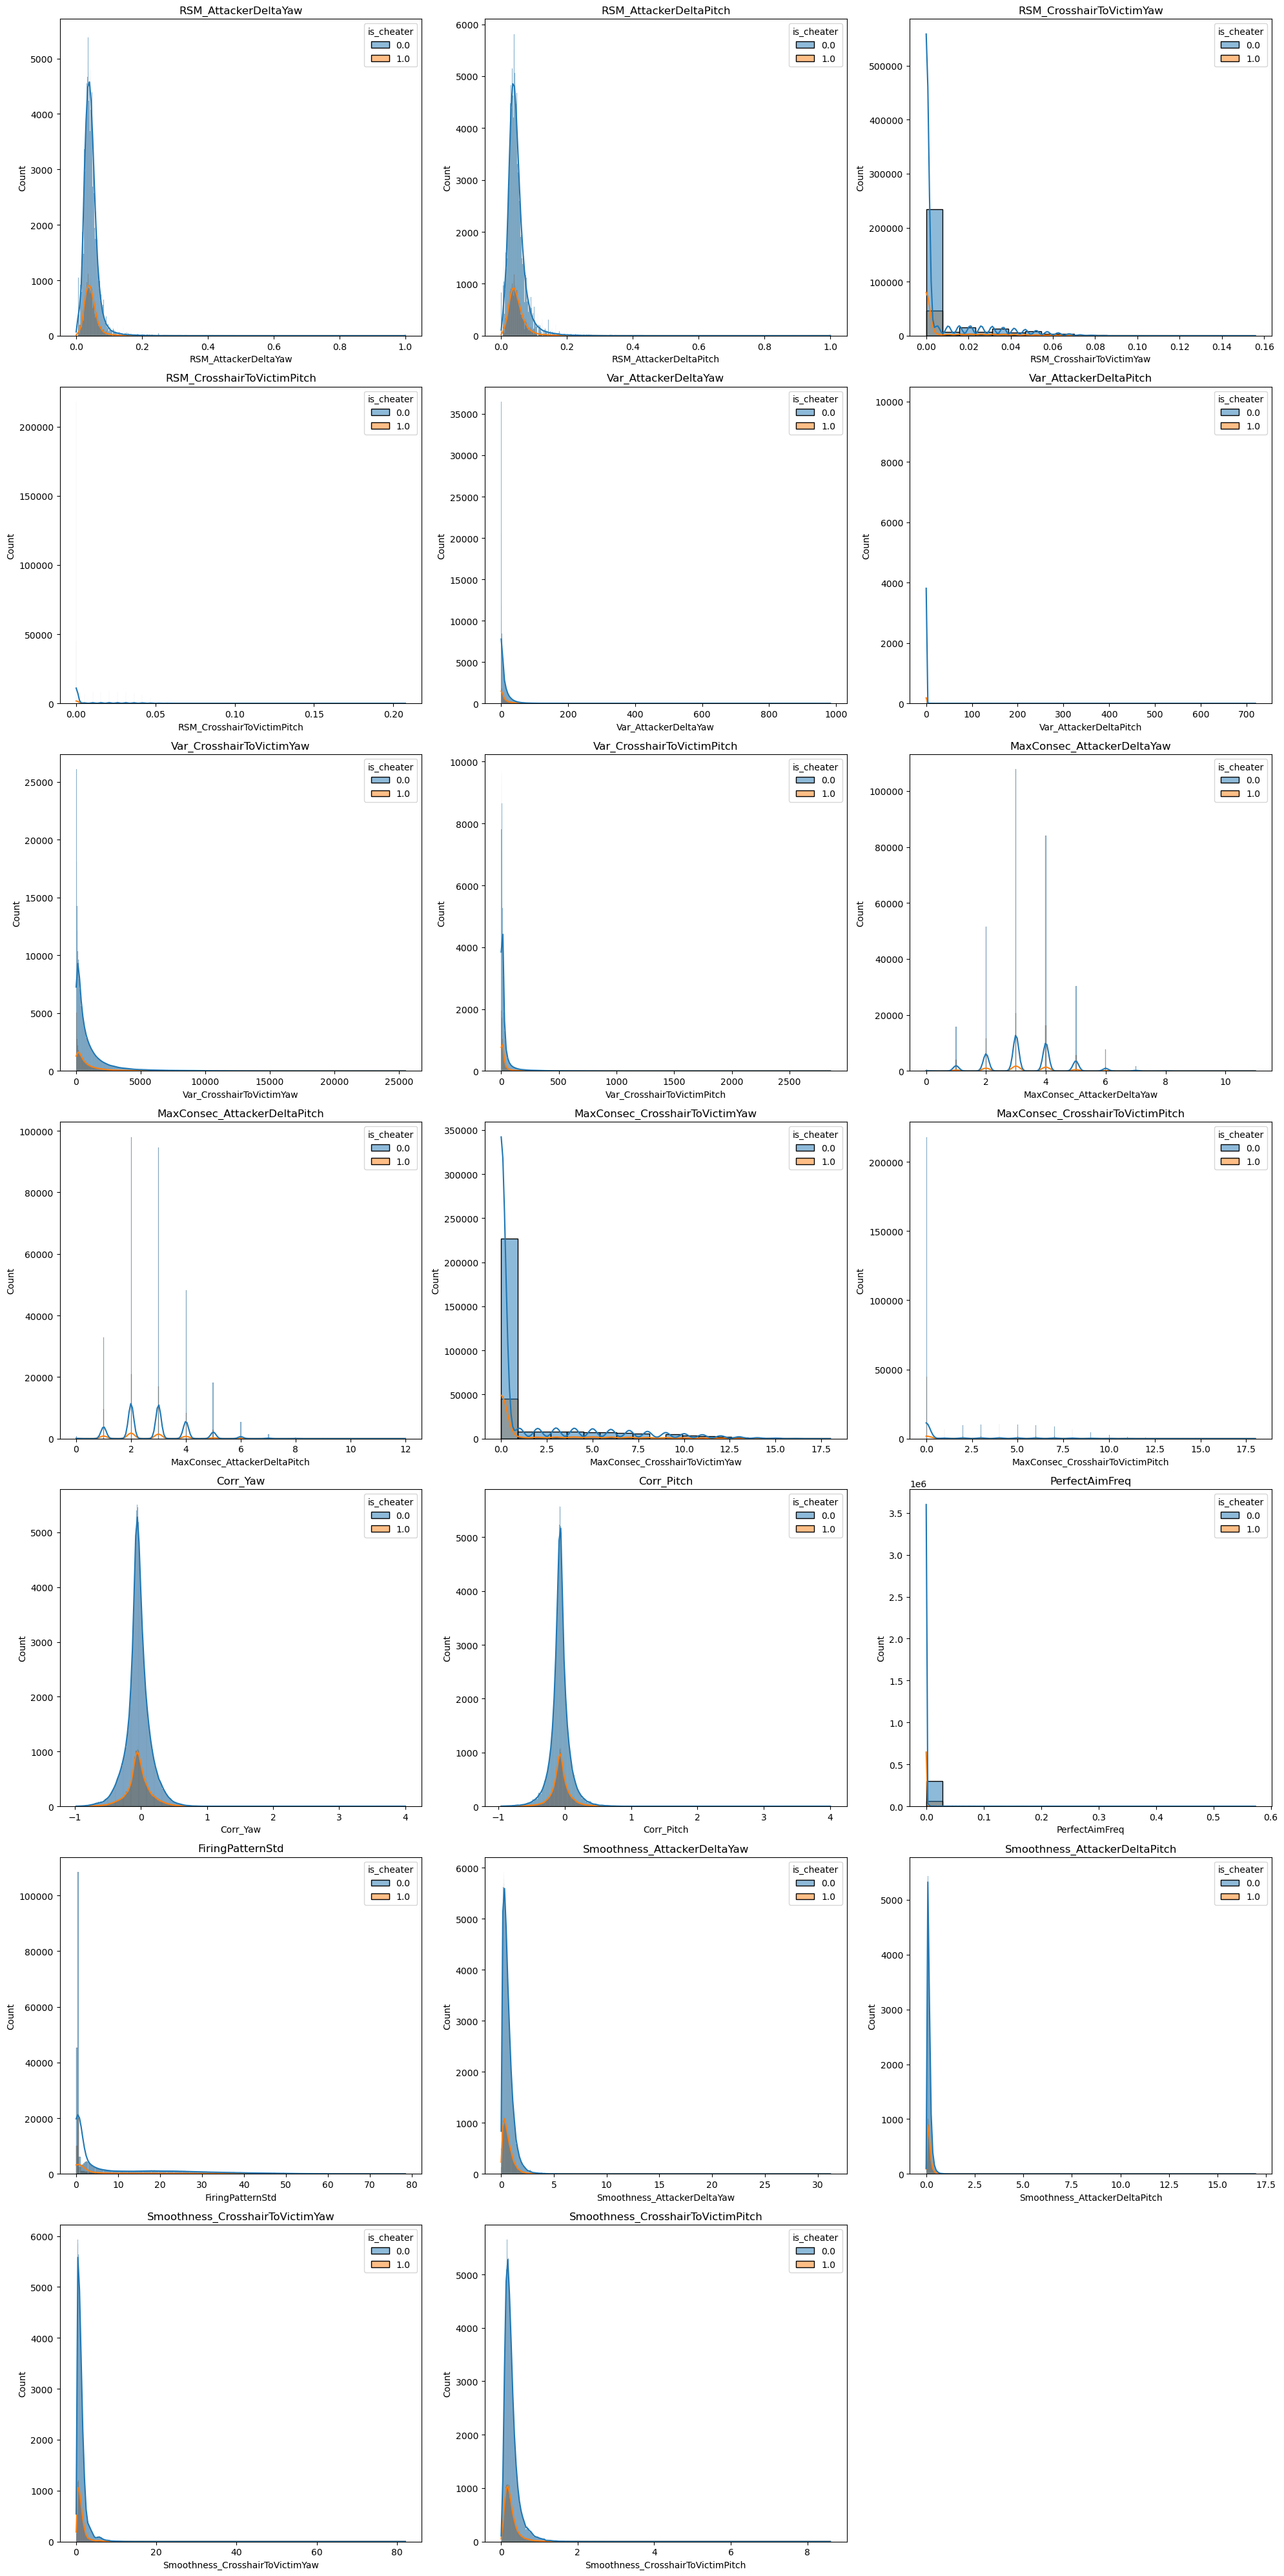

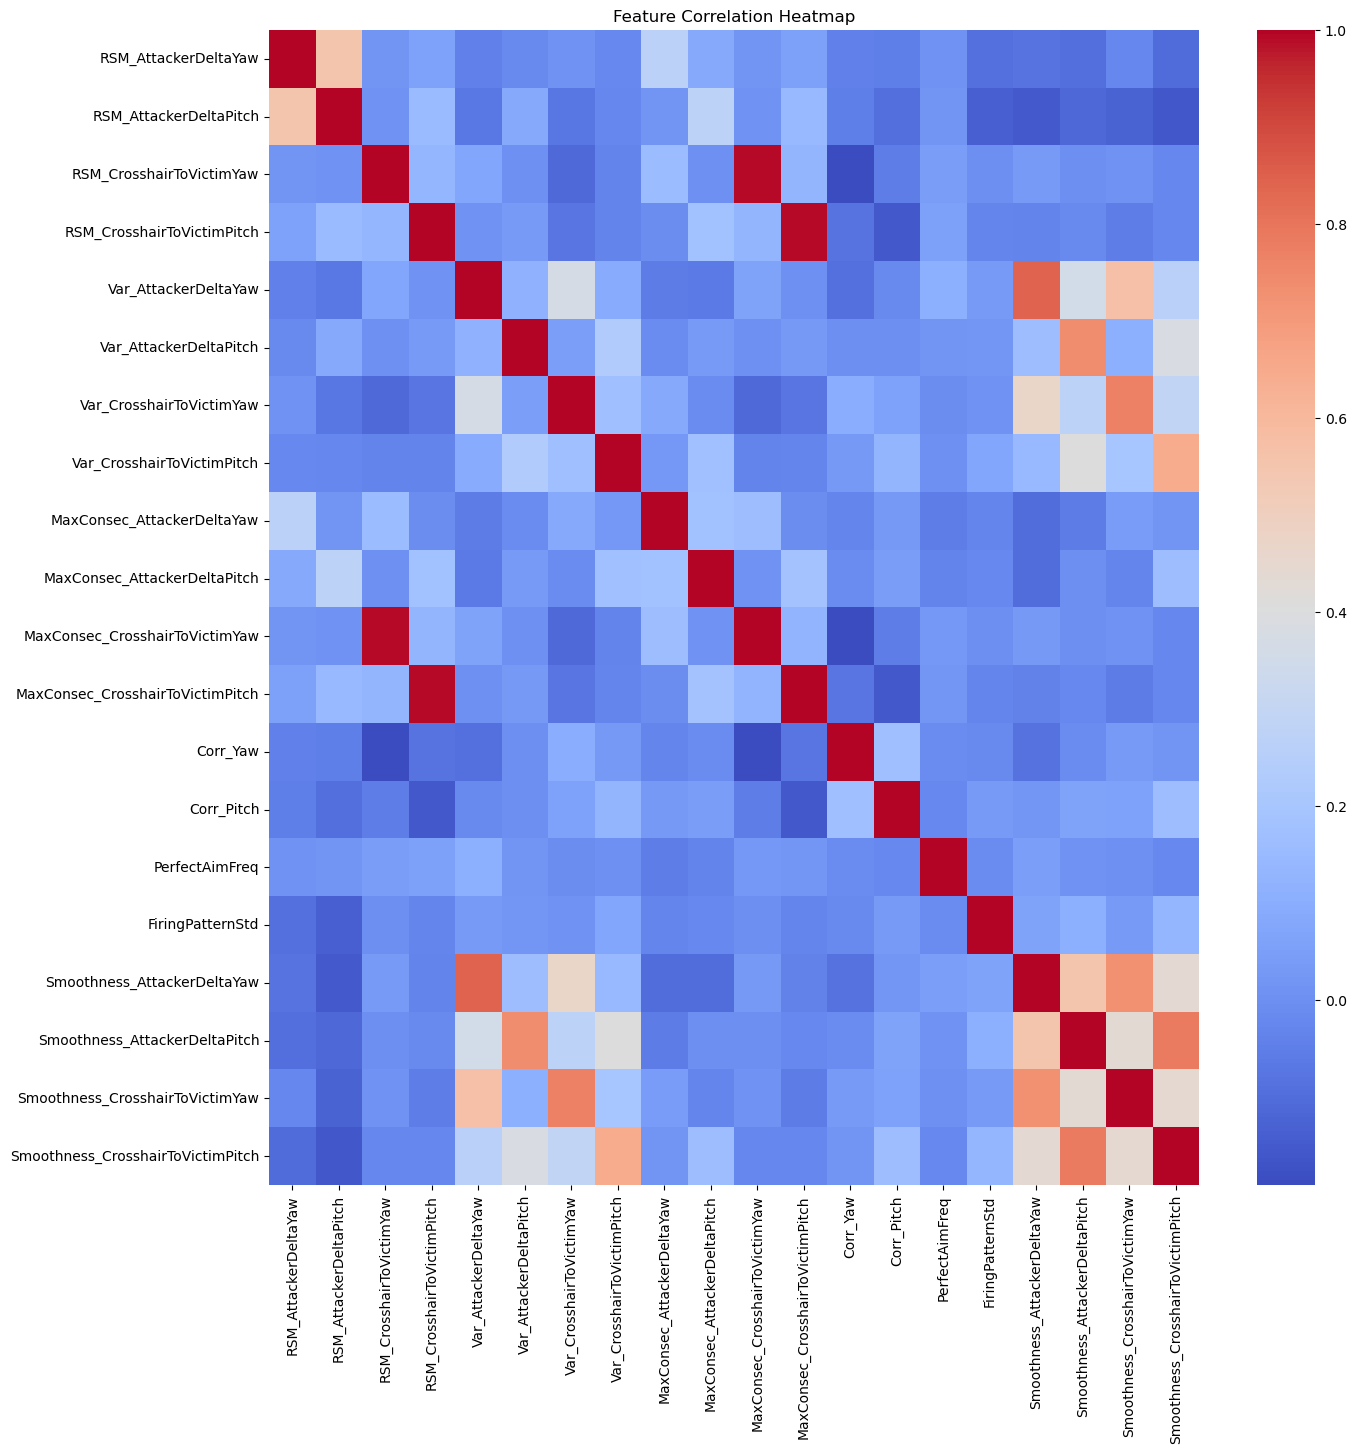

In [86]:
# Create a DataFrame for easier analysis
df = pd.DataFrame(X, columns=feature_names)
df['is_cheater'] = y

# Plot distribution of each feature
plt.figure(figsize=(20, 40))
for i, feature in enumerate(feature_names):
    plt.subplot(7, 3, i+1)
    sns.histplot(data=df, x=feature, hue='is_cheater', kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

# Compute correlation matrix
corr_matrix = df[feature_names].corr()

# Plot correlation heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

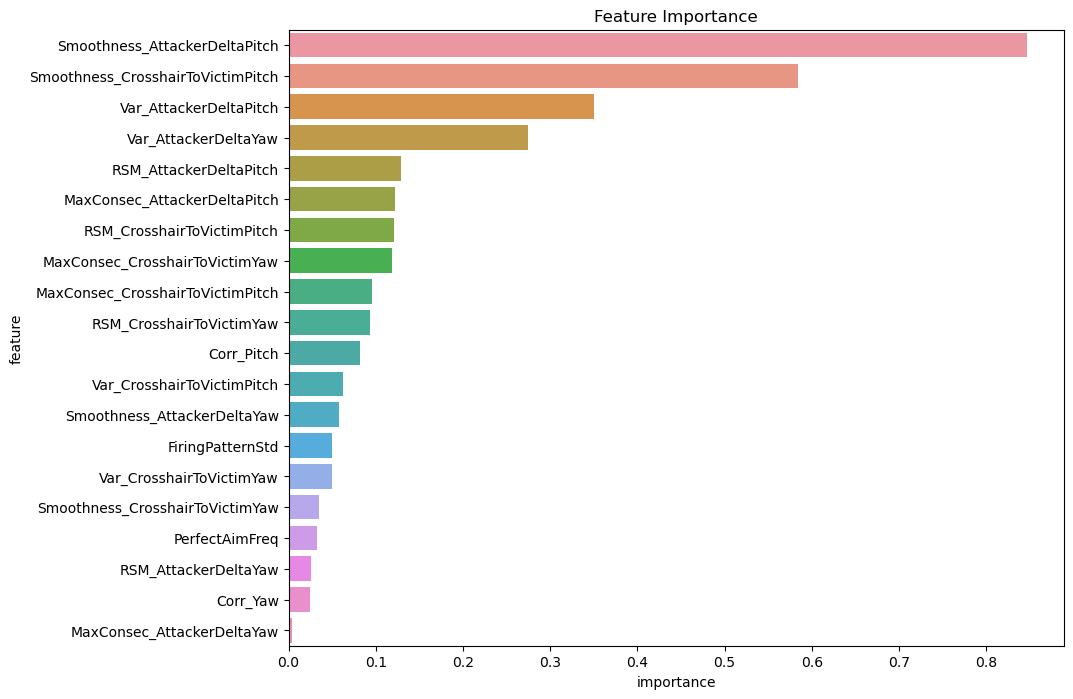

Top 5 most important features:
                              feature  importance
17      Smoothness_AttackerDeltaPitch    0.846656
19  Smoothness_CrosshairToVictimPitch    0.583929
5              Var_AttackerDeltaPitch    0.349938
4                Var_AttackerDeltaYaw    0.274044
1              RSM_AttackerDeltaPitch    0.128555


In [87]:
# Basic feature importance using logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lr = LogisticRegression(random_state=42)
lr.fit(X_scaled, y)

feature_importance = pd.DataFrame({'feature': feature_names, 'importance': np.abs(lr.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

# Print top 5 most important features
print("Top 5 most important features:")
print(feature_importance.head())

### Some things to note about working with Claude thus far:
1. Once the message starts to get long, you get a timer eg. x messages remaining until 5pm (deos this depend on type of subscription?)
2. Claude needs to be reminded of instructions from earlier on in the conversation - this could be a context length thing where it starts to forget earlier parts of the conversation. 
3. Early on in the chat though, it was very good at sticking to the guidance doc and planning how much time to spend on certain tasks. 
4. I noticed if you ask it to make sure its code is correct, it might say in text that there are some things it needs to change but it doesn't actually change them and just returns the same piece of code. (i might have seen this more in the earlier chats with the first version of the guidance doc - will have to check if this was the case in the latest chat too!

Note about #2: I asked it if it remembered the guidelines I gave it at the beginning of the conversation and it was able to recall them

#### Claude's response:

I apologize for not explicitly addressing the guidelines you provided at the beginning of our conversation. You're right to bring this up, as those guidelines are crucial for structuring our approach. Let me revisit those guidelines:

1. Recipe Approach: Provide a complete sequence of steps for each major phase of the project.
2. Cognitive Verification: Generate 3-5 additional questions for each step to ensure thorough understanding.
3. Question Refinement: Improve unclear questions by incorporating specific information about cheater detection.
4. Alternative Approaches: Provide at least two alternative approaches for major decision points.
5. Reflection: Explain the reasoning behind significant advice or code.
6. Fact Checking: Provide a list of key facts to be verified for technical details or methods.
7. Output Automation: Generate Python code snippets when appropriate.
8. Visualization Suggestions: Recommend appropriate visualizations at each stage.

You're absolutely correct that I should have been more explicitly following these guidelines in my responses. Thank you for bringing this to my attention. Would you like me to revise my previous response to align more closely with these guidelines, particularly for the steps remaining before the modeling stage?

### Steps left so far:

You're right to redirect me back to the guidance document. I apologize for not fully integrating it into my response. Let's realign our approach with the document's structure:

1. Feature Selection and Importance:
   - Finalize our reduced feature set based on correlation analysis and importance
   - Re-evaluate feature importance with the reduced set

2. Model Selection:
   - Choose Logistic Regression (linear) and Random Forest (non-linear)
   - Justify these choices based on our problem and data characteristics

3. Evaluation Metric Selection:
   - Determine appropriate metrics (e.g., accuracy, precision, recall, F1-score)
   - Explain why these metrics are suitable for our cheater detection problem

4. Cross-validation Strategies:
   - Decide on a cross-validation approach (e.g., k-fold cross-validation)
   - Implement cross-validation for both model selection and performance estimation

5. Hyperparameter Tuning:
   - Define hyperparameter ranges for both models
   - Implement a tuning strategy (e.g., grid search or random search with cross-validation)

6. Model Training and Evaluation:
   - Train both models with the best hyperparameters
   - Evaluate on a held-out test set
   - Compare performance using the chosen metrics

This approach more closely aligns with the structured process outlined in the guidance document, ensuring we don't skip crucial steps before the modeling stage. Would you like to proceed with this revised plan?

### Final decision on feature selection:

You're absolutely right, and I appreciate your astute observation. I apologize for not properly balancing the importance of features with their correlations. Your point is crucial and highlights the need for a more nuanced approach. Let's revise our feature selection strategy to address this issue:

Start with the most important feature: Smoothness_AttackerDeltaPitch
Exclude highly correlated features: Var_AttackerDeltaPitch and Smoothness_CrosshairToVictimPitch
Include the next most important uncorrelated feature: Var_AttackerDeltaYaw
Include RSM_AttackerDeltaPitch as it's in the top 5 and not highly correlated with the selected features

For the remaining features, we'll choose those that are important but not highly correlated with our already selected features.
Here's a revised feature selection:

1. Smoothness_AttackerDeltaPitch
2. Var_AttackerDeltaYaw
3. RSM_AttackerDeltaPitch
4. MaxConsec_AttackerDeltaYaw (not highly correlated with others)
5. MaxConsec_AttackerDeltaPitch (not highly correlated with others)
6. RSM_AttackerDeltaYaw (moderately correlated with RSM_AttackerDeltaPitch, but might still provide useful information)
7. Corr_Yaw
8. Corr_Pitch
9. PerfectAimFreq
10. FiringPatternStd

This selection aims to balance feature importance with minimizing correlations.

### Final feature engineering function versions!

In [3]:
from scipy.stats import zscore
import itertools

def ratio_sudden_movements(data, threshold=3):
    z_scores = np.abs(zscore(data, axis=0))
    sudden_movements = np.sum(z_scores > threshold, axis=0)
    total_movements = np.sum(np.abs(data) > 0, axis=0)
    return np.where(total_movements > 0, sudden_movements / total_movements, 0.0)

def max_consecutive_sudden(data, threshold=3):
    z_scores = np.abs(zscore(data, axis=0))
    sudden = z_scores > threshold
    return np.array([max([len(list(group)) for key, group in itertools.groupby(col) if key], default=0) for col in sudden.T])

def crosshair_movement_correlation(data):
    def corr_with_special_cases(x, y):
        if np.std(x) == 0 and np.std(y) == 0:
            return 4.0
        elif np.std(x) == 0:
            return 2.0
        elif np.std(y) == 0:
            return 3.0
        else:
            return np.corrcoef(x, y)[0, 1]

    yaw_corr = corr_with_special_cases(data[:, 0], data[:, 2])
    pitch_corr = corr_with_special_cases(data[:, 1], data[:, 3])
    return np.array([yaw_corr, pitch_corr])

def perfect_aim_frequency(data, precision=0.001):
    return np.sum((np.abs(data[:, 2]) < precision) & (np.abs(data[:, 3]) < precision), axis=0) / data.shape[0]

def firing_pattern(data):
    fire_times = np.where(data[:, 4] == 1)[0]
    if len(fire_times) > 1:
        return np.std(np.diff(fire_times))
    return 0

def extract_reduced_features(engagement_data):
    features = []
    # 1. Smoothness_AttackerDeltaPitch
    features.append(np.mean(np.abs(np.diff(engagement_data[:, 1]))))
    # 2. Var_AttackerDeltaYaw
    features.append(np.var(engagement_data[:, 0]))
    # 3. RSM_AttackerDeltaPitch
    features.append(ratio_sudden_movements(engagement_data[:, 1:2])[0])
    # 4-5. MaxConsec features
    features.extend(max_consecutive_sudden(engagement_data[:, :2]))
    # 6. RSM_AttackerDeltaYaw
    features.append(ratio_sudden_movements(engagement_data[:, 0:1])[0])
    # 7-8. Correlation features
    features.extend(crosshair_movement_correlation(engagement_data))
    # 9. PerfectAimFreq
    features.append(perfect_aim_frequency(engagement_data))
    # 10. FiringPatternStd
    features.append(firing_pattern(engagement_data))
    
    return features

# Updated feature names
feature_names = [
    'Smoothness_AttackerDeltaPitch', 'Var_AttackerDeltaYaw', 'RSM_AttackerDeltaPitch',
    'MaxConsec_AttackerDeltaYaw', 'MaxConsec_AttackerDeltaPitch',
    'RSM_AttackerDeltaYaw', 'Corr_Yaw', 'Corr_Pitch',
    'PerfectAimFreq', 'FiringPatternStd'
]

# Apply feature extraction to both datasets
cheater_features = np.array([extract_reduced_features(engagement) for player in cheaters_data for engagement in player])
legit_features = np.array([extract_reduced_features(engagement) for player in legit_data for engagement in player])

# Combine features and create labels
X = np.vstack((cheater_features, legit_features))
y = np.hstack((np.ones(cheater_features.shape[0]), np.zeros(legit_features.shape[0])))

/Users/asadm2/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [89]:
# Re-evaluate feature importance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lr = LogisticRegression(random_state=42)
lr.fit(X_scaled, y)

feature_importance = pd.DataFrame({'feature': feature_names, 'importance': np.abs(lr.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False)

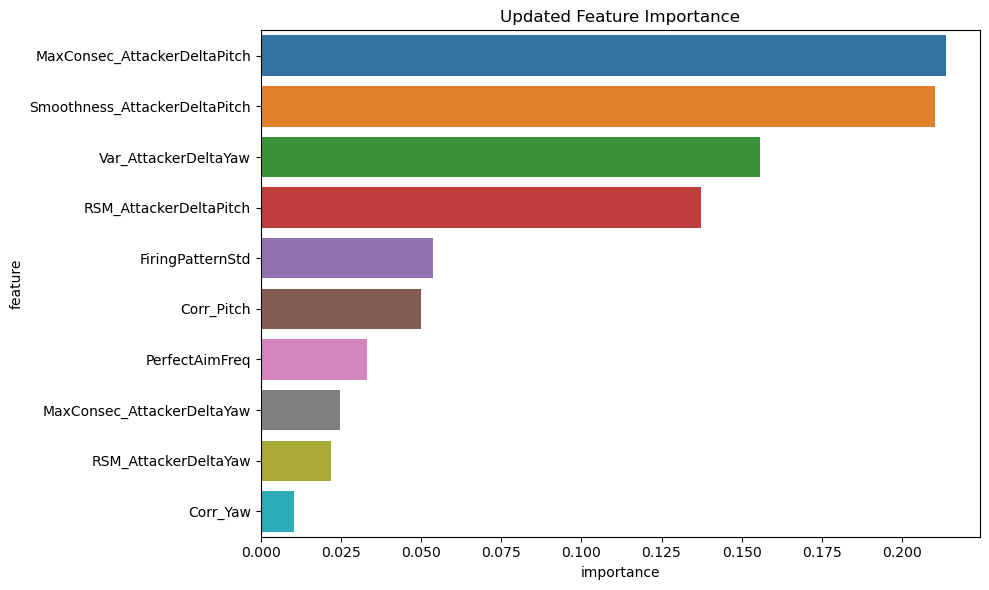

Feature importance ranking:
                         feature  importance
4   MaxConsec_AttackerDeltaPitch    0.213687
0  Smoothness_AttackerDeltaPitch    0.210458
1           Var_AttackerDeltaYaw    0.155866
2         RSM_AttackerDeltaPitch    0.137322
9               FiringPatternStd    0.053567
7                     Corr_Pitch    0.049897
8                 PerfectAimFreq    0.032974
3     MaxConsec_AttackerDeltaYaw    0.024816
5           RSM_AttackerDeltaYaw    0.021885
6                       Corr_Yaw    0.010414


In [90]:
# Visualize updated feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Updated Feature Importance')
plt.tight_layout()
plt.show()

print("Feature importance ranking:")
print(feature_importance)

### Moving on to modeling

Here's our plan for the modeling stage:

1. Model Selection:

We've already chosen our models:

a) Logistic Regression (with 3 selected features)
b) Random Forest 1 (with 3 selected features)
c) Random Forest 2 (with all 10 engineered features)


2. Evaluation Metric Selection:

We'll use F1 score as our primary metric, given the class imbalance and the need to balance between false positives and false negatives. We'll also look at accuracy, precision, and recall for a comprehensive evaluation.

3. Cross-validation Strategy:

We'll use GroupKFold to ensure all engagements from a single player stay together in either the training or testing set.

4. Hyperparameter Tuning:

We'll use RandomizedSearchCV for hyperparameter tuning, as it's more efficient than exhaustive grid search.

5. Model Training and Evaluation:

We'll train each model with the best hyperparameters and evaluate them using our chosen metrics.

### I wanted to use a more robust way of doing feature selection so this code includes RFE with CV - specifically grouped CV - because I want to ensure that all engagements from a single player stay together. the metric selected is F1.

In [5]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.metrics import make_scorer, f1_score

# Assuming X, y, and feature_names are already defined

# Create player IDs
n_legit_players = 10000
n_cheater_players = 2000
n_engagements = 30

player_ids = np.repeat(np.arange(n_legit_players + n_cheater_players), n_engagements)

In [6]:
# Create the group k-fold object
group_kfold = GroupKFold(n_splits=5)

# Create an F1 scorer
f1_scorer = make_scorer(f1_score, average='weighted')

# Create the RFECV object
estimator = LogisticRegression(max_iter=1000, class_weight='balanced')
selector = RFECV(estimator, step=1, cv=group_kfold, scoring=f1_scorer, n_jobs=-1)

# Fit the selector
selector = selector.fit(X, y, groups=player_ids)

# Get the selected features
selected_features = np.array(feature_names)[selector.support_]
X_selected = X[:, selector.support_]

print("Selected features:", selected_features)
print("Number of selected features:", len(selected_features))

Selected features: ['Smoothness_AttackerDeltaPitch' 'RSM_AttackerDeltaPitch' 'PerfectAimFreq']
Number of selected features: 3


/Users/asadm2/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


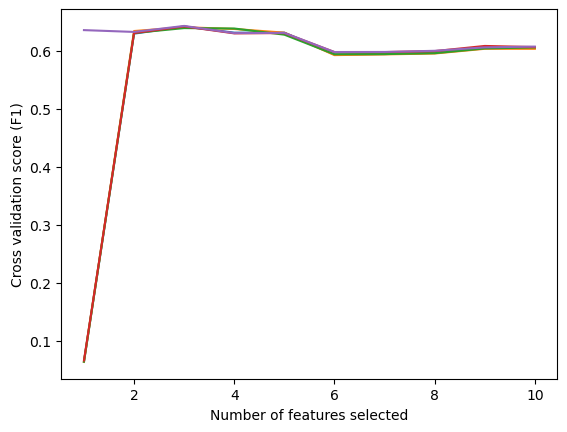


Feature ranking (lower is better):
Smoothness_AttackerDeltaPitch: 1
RSM_AttackerDeltaPitch: 1
PerfectAimFreq: 1
RSM_AttackerDeltaYaw: 2
Corr_Pitch: 3
MaxConsec_AttackerDeltaPitch: 4
Corr_Yaw: 5
MaxConsec_AttackerDeltaYaw: 6
Var_AttackerDeltaYaw: 7
FiringPatternStd: 8


In [7]:
# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (F1)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

# Print the ranking of features
feature_ranking = sorted(zip(feature_names, selector.ranking_), key=lambda x: x[1])
print("\nFeature ranking (lower is better):")
for feature, rank in feature_ranking:
    print(f"{feature}: {rank}")

### Hyperparameter tuning using groupKfold CV and randomizedSearchCV

In [12]:
from sklearn.model_selection import GroupKFold, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

# Assuming X, y, player_ids, and feature_names are already defined
# X_selected is the dataset with 3 selected features
# X_all is the dataset with all 10 features

def evaluate_model(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }

In [13]:
# Split data into train+val and test sets
X_train_val, X_test, y_train_val, y_test, player_ids_train_val, player_ids_test = train_test_split(
    X, y, player_ids, test_size=0.2, stratify=y, random_state=42
)

In [14]:
X_selected

array([[0.06395812, 0.05747126, 0.        ],
       [0.10284292, 0.07142857, 0.        ],
       [0.27405235, 0.01960784, 0.        ],
       ...,
       [0.04039267, 0.0952381 , 0.        ],
       [0.15734032, 0.01398601, 0.        ],
       [0.04246597, 0.04081633, 0.        ]])

In [16]:
# Extract selected features for models that use them
selected_feature_indices = [0, 2, 8]  # Indices of the selected features
X_selected_train_val = X_train_val[:, selected_feature_indices]
X_selected_test = X_test[:, selected_feature_indices] 

In [17]:
# Scale the features
scaler_all = StandardScaler()
X_all_train_val_scaled = scaler_all.fit_transform(X_train_val)
X_all_test_scaled = scaler_all.transform(X_test)

In [18]:
scaler_selected = StandardScaler()
X_selected_train_val_scaled = scaler_selected.fit_transform(X_selected_train_val)
X_selected_test_scaled = scaler_selected.transform(X_selected_test)

In [19]:
# Set up cross-validation
cv = GroupKFold(n_splits=5)

### Logistic regression with top 3 features

In [20]:
# Logistic Regression
lr_params = {
    'C': np.logspace(-4, 4, 20),
    'class_weight': [None, 'balanced']
}
lr = RandomizedSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=cv, scoring='f1', n_iter=20, n_jobs=-1)
lr.fit(X_selected_train_val_scaled, y_train_val, groups=player_ids_train_val)

RandomizedSearchCV(cv=GroupKFold(n_splits=5),
                   estimator=LogisticRegression(max_iter=1000), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'class_weight': [None, 'balanced']},
                   scoring='f1')

### Random forest with top 3 features

In [37]:
# Random Forest 1 (3 features)
rf1_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}
rf1 = RandomizedSearchCV(RandomForestClassifier(random_state=31), rf1_params, cv=cv, scoring='f1', \
                         random_state=31, n_iter=10, n_jobs=1, verbose=10)
rf1.fit(X_selected_train_val_scaled, y_train_val, groups=player_ids_train_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START class_weight=None, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200
[CV 1/5; 1/10] END class_weight=None, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.010 total time=  53.4s
[CV 2/5; 1/10] START class_weight=None, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200
[CV 2/5; 1/10] END class_weight=None, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.001 total time=  52.0s
[CV 3/5; 1/10] START class_weight=None, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200
[CV 3/5; 1/10] END class_weight=None, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.005 total time=  53.2s
[CV 4/5; 1/10] START class_weight=None, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200
[CV 4/5; 1/10] END class_weight=None, max_depth=20, min

[CV 2/5; 7/10] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.000 total time=  16.5s
[CV 3/5; 7/10] START class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 3/5; 7/10] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.004 total time=  16.1s
[CV 4/5; 7/10] START class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 4/5; 7/10] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.001 total time=  15.8s
[CV 5/5; 7/10] START class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 5/5; 7/10] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.000 total time=  15.4s
[CV 1/5; 8/10] START class_weight=None, max_depth=None, min_samples_leaf=2, min_sampl

RandomizedSearchCV(cv=GroupKFold(n_splits=5),
                   estimator=RandomForestClassifier(random_state=31), n_jobs=1,
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=31, scoring='f1', verbose=10)

### Random forest with all features

In [38]:
# Random Forest 2 (all features)
rf2 = RandomizedSearchCV(RandomForestClassifier(random_state=31), rf1_params, cv=cv, scoring='f1', \
                         random_state=31, n_iter=10, n_jobs=1, verbose=10)
rf2.fit(X_all_train_val_scaled, y_train_val, groups=player_ids_train_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START class_weight=None, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200
[CV 1/5; 1/10] END class_weight=None, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.043 total time= 1.9min
[CV 2/5; 1/10] START class_weight=None, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200
[CV 2/5; 1/10] END class_weight=None, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.031 total time= 1.8min
[CV 3/5; 1/10] START class_weight=None, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200
[CV 3/5; 1/10] END class_weight=None, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.034 total time= 1.8min
[CV 4/5; 1/10] START class_weight=None, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200
[CV 4/5; 1/10] END class_weight=None, max_depth=20, min

[CV 2/5; 7/10] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.008 total time=  33.8s
[CV 3/5; 7/10] START class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 3/5; 7/10] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.012 total time=  34.3s
[CV 4/5; 7/10] START class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 4/5; 7/10] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.012 total time=  34.4s
[CV 5/5; 7/10] START class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 5/5; 7/10] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.012 total time=  34.4s
[CV 1/5; 8/10] START class_weight=None, max_depth=None, min_samples_leaf=2, min_sampl

RandomizedSearchCV(cv=GroupKFold(n_splits=5),
                   estimator=RandomForestClassifier(random_state=31), n_jobs=1,
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=31, scoring='f1', verbose=10)

### Evaluation

In [39]:
# Evaluate models on test set
models = {
    'Logistic Regression': (lr, X_selected_test_scaled),
    'Random Forest (3 features)': (rf1, X_selected_test_scaled),
    'Random Forest (all features)': (rf2, X_all_test_scaled)
}

In [40]:
results = {}
for name, (model, X_test_scaled) in models.items():
    y_pred = model.predict(X_test_scaled)
    results[name] = evaluate_model(y_test, y_pred)
    print(f"\n{name} Results:")
    for metric, value in results[name].items():
        print(f"{metric}: {value:.4f}")
    
    if isinstance(model.best_estimator_, RandomForestClassifier):
        importances = model.best_estimator_.feature_importances_
        feature_imp = pd.DataFrame({'feature': feature_names[:X_test_scaled.shape[1]], 'importance': importances})
        feature_imp = feature_imp.sort_values('importance', ascending=False)
        print("\nFeature Importances:")
        print(feature_imp)


Logistic Regression Results:
accuracy: 0.5913
precision: 0.1878
recall: 0.4368
f1: 0.2627

Random Forest (3 features) Results:
accuracy: 0.5689
precision: 0.1884
recall: 0.4799
f1: 0.2706

Feature Importances:
                         feature  importance
0  Smoothness_AttackerDeltaPitch    0.539293
1           Var_AttackerDeltaYaw    0.372465
2         RSM_AttackerDeltaPitch    0.088242

Random Forest (all features) Results:
accuracy: 0.6815
precision: 0.2497
recall: 0.4544
f1: 0.3223

Feature Importances:
                         feature  importance
9               FiringPatternStd    0.150162
2         RSM_AttackerDeltaPitch    0.149238
4   MaxConsec_AttackerDeltaPitch    0.140402
0  Smoothness_AttackerDeltaPitch    0.138842
1           Var_AttackerDeltaYaw    0.117679
7                     Corr_Pitch    0.089510
5           RSM_AttackerDeltaYaw    0.082696
6                       Corr_Yaw    0.080112
3     MaxConsec_AttackerDeltaYaw    0.036714
8                 PerfectAimFreq    0

In [41]:
# Compare models
print("\nModel Comparison (F1 Scores on Test Set):")
for name, result in results.items():
    print(f"{name}: {result['f1']:.4f}")


Model Comparison (F1 Scores on Test Set):
Logistic Regression: 0.2627
Random Forest (3 features): 0.2706
Random Forest (all features): 0.3223


### Classification threshold experiments

### Adjusting the classification threshold to balance precision and recall better

In [42]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Assuming rf2 is your Random Forest model with all features
y_scores = rf2.predict_proba(X_all_test_scaled)[:, 1]

In [43]:
# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

In [44]:
# Find threshold that gives the best F1 score
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores[:-1])]  # exclude the last element as it's always 1


In [45]:
# Make predictions with the new threshold
y_pred_new = (y_scores >= best_threshold).astype(int)

In [49]:
# Calculate new metrics
new_precision = precision_score(y_test, y_pred_new)
new_recall = recall_score(y_test, y_pred_new)
new_f1 = f1_score(y_test, y_pred_new)

print(f"New Precision: {new_precision:.4f}")
print(f"Best Threshold: {best_threshold:.4f}")
print(f"New Recall: {new_recall:.4f}")
print(f"New F1 Score: {new_f1:.4f}")

New Precision: 0.2245
Best Threshold: 0.4780
New Recall: 0.6009
New F1 Score: 0.3268


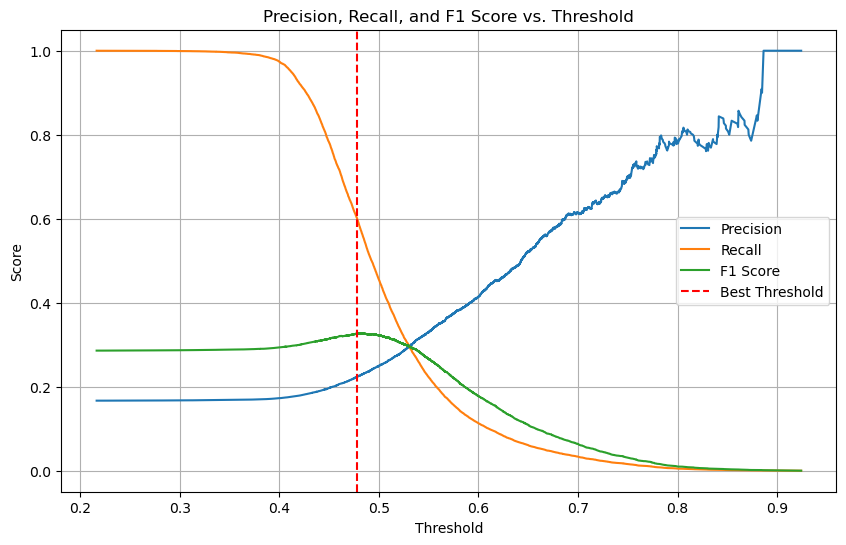

In [48]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(best_threshold, color='r', linestyle='--', label='Best Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

### Optimizing for precision of 0.9

Best Threshold for 90.00% precision: 0.8849
New Precision: 0.9000
New Recall: 0.0008


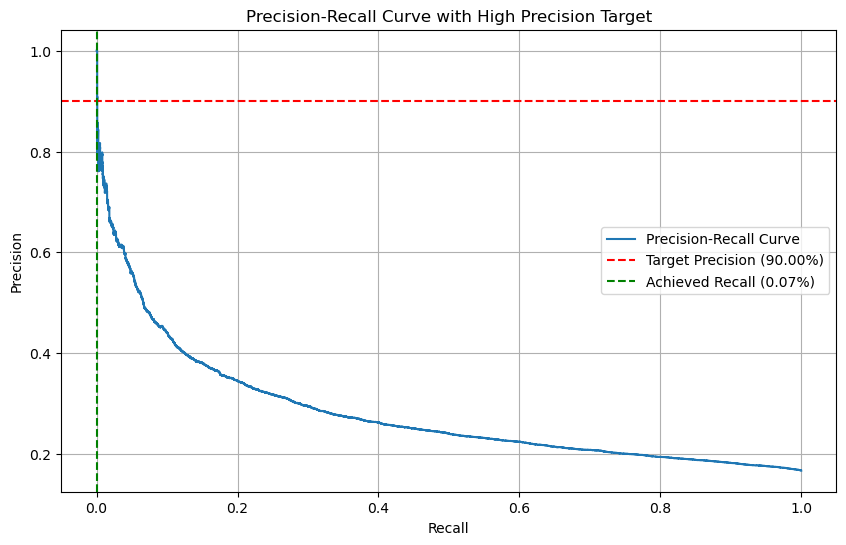

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

# Assuming rf2 is your Random Forest model with all features
# and X_all_test_scaled, y_test are your test data

# Get probability scores for the positive class (cheaters)
y_scores = rf2.predict_proba(X_all_test_scaled)[:, 1]

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Set a target precision (e.g., 90%)
target_precision = 0.90

# Find the threshold that gives precision closest to but not less than the target
valid_indices = precisions[:-1] >= target_precision  # Exclude the last precision value
if sum(valid_indices) > 0:
    best_threshold_index = np.argmin(np.abs(precisions[:-1][valid_indices] - target_precision))
    best_threshold = thresholds[valid_indices][best_threshold_index]
else:
    best_threshold = thresholds[-1]  # Most conservative threshold if target precision not achievable

# Make predictions with the new threshold
y_pred_new = (y_scores >= best_threshold).astype(int)

# Calculate new metrics
new_precision = precision_score(y_test, y_pred_new)
new_recall = recall_score(y_test, y_pred_new)

print(f"Best Threshold for {target_precision:.2%} precision: {best_threshold:.4f}")
print(f"New Precision: {new_precision:.4f}")
print(f"New Recall: {new_recall:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, label='Precision-Recall Curve')
plt.axhline(y=target_precision, color='r', linestyle='--', label=f'Target Precision ({target_precision:.2%})')
plt.axvline(x=new_recall, color='g', linestyle='--', label=f'Achieved Recall ({new_recall:.2%})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with High Precision Target')
plt.legend()
plt.grid(True)
plt.show()

### Experimenting with different precision levels

Results for different precision targets:
Target: 0.90, Threshold: 0.8849, Precision: 0.9000, Recall: 0.0008, F1: 0.0015
Target: 0.80, Threshold: 0.8096, Precision: 0.8000, Recall: 0.0043, F1: 0.0086
Target: 0.70, Threshold: 0.7524, Precision: 0.7000, Recall: 0.0152, F1: 0.0297
Target: 0.60, Threshold: 0.6867, Precision: 0.6000, Recall: 0.0393, F1: 0.0737
Target: 0.50, Threshold: 0.6427, Precision: 0.5000, Recall: 0.0664, F1: 0.1173

Break-even point: Threshold: 0.5304, Score: 0.2963, F1: 0.2963


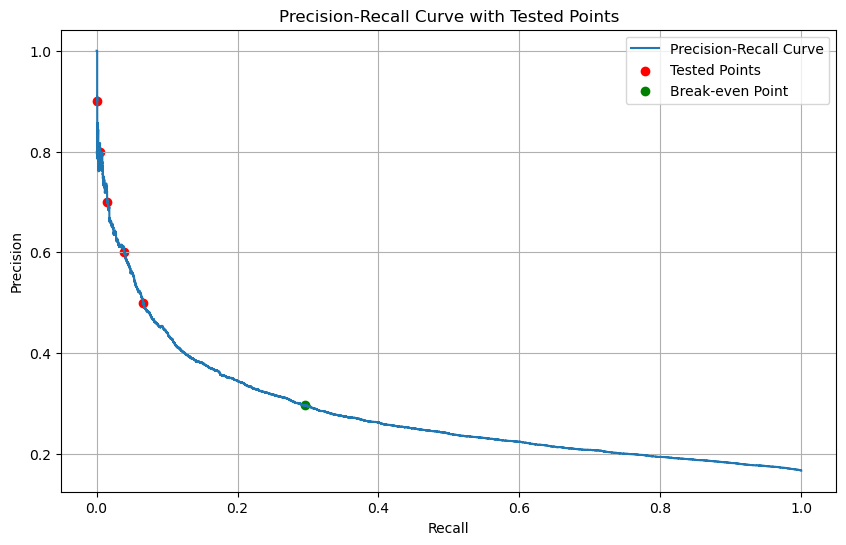

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score

# Assuming rf2 is your Random Forest model with all features
# and X_all_test_scaled, y_test are your test data

y_scores = rf2.predict_proba(X_all_test_scaled)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Test different precision targets
precision_targets = [0.9, 0.8, 0.7, 0.6, 0.5]
results = []

for target in precision_targets:
    valid_indices = precisions[:-1] >= target
    if sum(valid_indices) > 0:
        best_index = np.argmin(np.abs(precisions[:-1][valid_indices] - target))
        threshold = thresholds[valid_indices][best_index]
        y_pred = (y_scores >= threshold).astype(int)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results.append((target, threshold, prec, rec, f1))

# Find precision-recall break-even point
break_even_index = np.argmin(np.abs(precisions - recalls))
break_even_threshold = thresholds[break_even_index]
break_even_score = (precisions[break_even_index] + recalls[break_even_index]) / 2
y_pred_break_even = (y_scores >= break_even_threshold).astype(int)
break_even_f1 = f1_score(y_test, y_pred_break_even)

# Print results
print("Results for different precision targets:")
for target, threshold, prec, rec, f1 in results:
    print(f"Target: {target:.2f}, Threshold: {threshold:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

print(f"\nBreak-even point: Threshold: {break_even_threshold:.4f}, Score: {break_even_score:.4f}, F1: {break_even_f1:.4f}")

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, label='Precision-Recall Curve')
plt.scatter([r for _, _, _, r, _ in results], [p for _, _, p, _, _ in results], color='red', label='Tested Points')
plt.scatter(recalls[break_even_index], precisions[break_even_index], color='green', label='Break-even Point')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Tested Points')
plt.legend()
plt.grid(True)
plt.show()